### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Summer 2023 ###

# Optimizing Resource Management in Video Games: Role Playing as Oppenheimer in Factorio #

#### Laik Ruetten (lruetten@wisc.edu)

# Intro: Nuclear Power in Factorio

Laik has recently started playing Factorio, which is a game about mining resources and crafting and refining them into products. Every item takes a different amount of time and resources to craft and a different amount of electricity to run. It would be fun to have an objective of something specific like simulate the Manhattan Project and get nuclear energy/atomic bombs as quickly as possible.

I got the idea of optimizing tasks within Factorio from the folder of previous semester's project examples. Having recently gotten into the game, this caught my eye. I enjoyed reading through their project the most, but I wanted to tackle a different problem within the game, leading to a completely different project with a different angle.

I have been exploring the structure of the model needed to create nuclear energy and atomic bombs. There are many different components with different crafting recipes for each step. I also brainstormed what kinds of optimization questions I can ask after experimenting a bit. Below are a lot of my notes on the nuclear energy system in the game, all of which has been taken from https://wiki.factorio.com/.

## Questions I could ask

In the beginning, I had not yet decided what my objective to optimize will be, but here is a list of some of my brain stormed ideas.

- One one train load, how much U-235 and U-238 can we produce?
- How fast can we produce that much enriched uranium?
- How much power can we produce with that much?
- How much iron do we need for that much uranium?

- Can I formulate this into a max flow problem to produce as much power as efficiently as possible?

- Can we minimize the amount of pollution?
- Can we minimize our energy consumption for all of these machines?

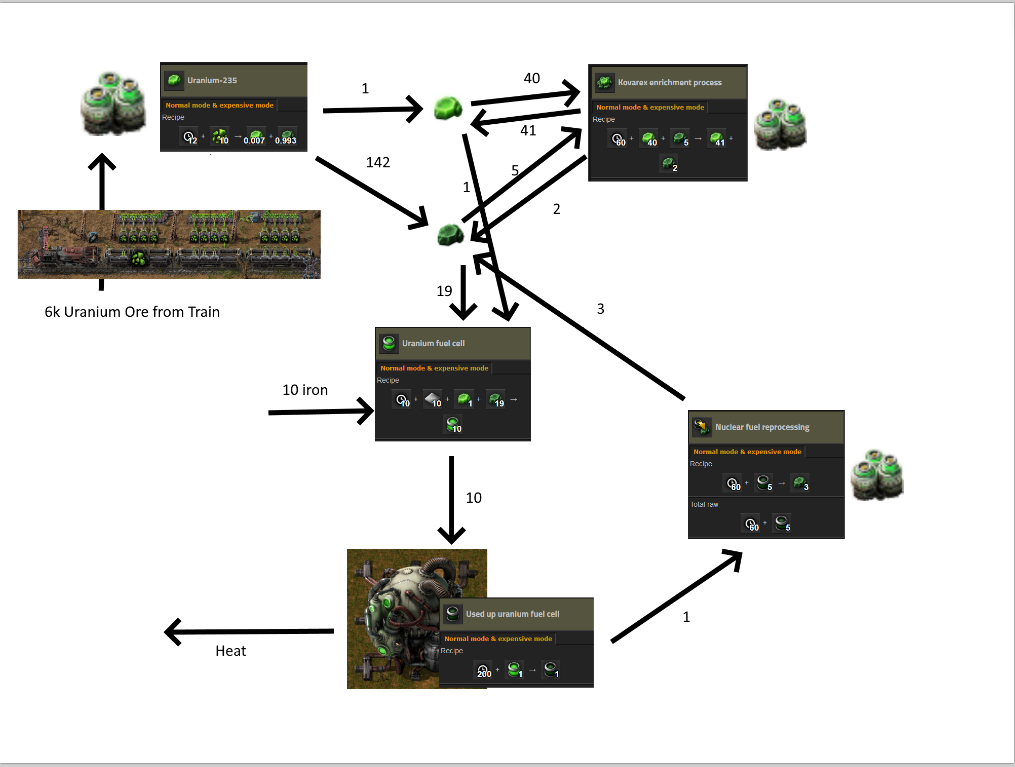

## Processing Uranium Ore

https://wiki.factorio.com/Uranium_processing

https://wiki.factorio.com/Uranium-235

10 Uranium ore can be used in a centrifuge to produce Uranium-235 with a 0.007 probability and Uranium-238 with a 0.993 probability.
This process takes 12 seconds

This leads to an expected (not guaranteed) 1 unit of unranium-235 per approximately 143 processing cycles.
p=0.007
E(1,p) = 1/p = ~143

(or about 1:142 ratio of U-235 to U-238)

The Kovarez enrichment process can turn 40 U-235 + 5 U-238 -> 41 U-235 + 2 U-238
This process takes 60 seconds.

The expected number of cycles to gain 40 units is then E(40, p) = 40 * E(1, p) = ~5714 cycles
Note that running this many cycles requires mining 57140 uranium ore.

However, given the nature of probability, it is impossible to guarantee that 40 units will be reached in this number of cycles; as a matter of fact, some mathematics yields that the probability that 5,714 cycles will produce at least 40 units of U-235 is only about 52%. 

Both of these are produced by a centrifuge.

## Confidence levels

Some further mathematics enables one to calculate the number of uranium processing cycles one must run to obtain at least 40 units of U-235 (given p = 0.007) with a given level of confidence (probability of achieving the set goal).

As discussed in the previous section, the level of confidence corresponding to 5,714 cycles (for which the expected value of U-235 gained is 40) happens to be about 52% (or, in other words, with this number of cycles, one can expect to fail to reach 40 U-235 a bit less than once out of every 2 tries).

Some further example confidence levels that may be of interest to players are given in the table below. Consult the chart to the right for custom values.

| Confidence level  |	Failures  | 	Cycles required to get 40   |
|--|--|--|
| 10% |	9 out of 10  |	4,595     |
| 50% |	1 out of 2 	 | 5,667     |
| 90% |	1 out of 10  |	6,894     |  
| 95% |	1 out of 20  |	7,272     |
| 99% |	1 out of 100 |	8,015      |

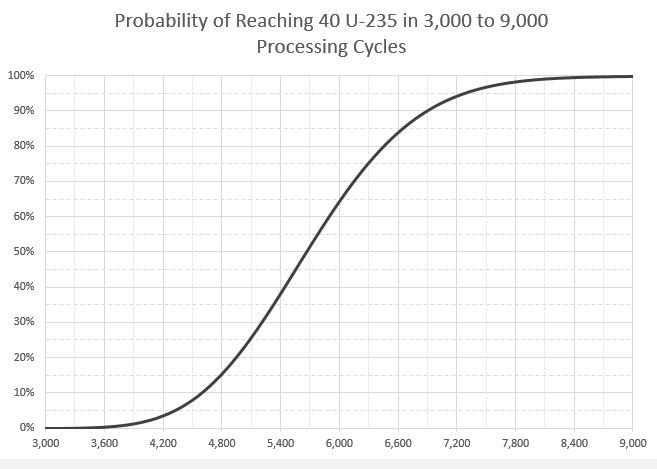

## First math model

Below is a simple model to try to confirm the information above in a different way. I can conclude that I need at least ~143 cycles to get 1 U-235, which requires ~1429 uranium ore.

In [1]:
# Specify packages I am using
using JuMP, Clp
# Create a new model
m = Model()

# Define variables
# We can optionally include bounds on each variable
@variable(m, N_ore >= 0)

# Define objective
@objective(m, Min, N_ore)

# Define constraints
@constraint(m, N_u235, N_ore/10 * 0.007 >= 1)
; #suppress output

println("Solve using Clp")

# Specify using the Clp optimizer
set_optimizer(m, Clp.Optimizer)

# Use the @time macro to measure the amount of time it takes to solve m
@time(optimize!(m))

println("N_ore: ", value(N_ore))
println("objective: ", objective_value(m))

Solve using Clp
  1.609842 seconds (2.73 M allocations: 180.414 MiB, 4.00% gc time, 99.88% compilation time)
N_ore: 1428.5714285714284
objective: 1428.5714285714284
Coin0506I Presolve 0 (-1) rows, 0 (-1) columns and 0 (-1) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 1428.5714
Coin0511I After Postsolve, objective 1428.5714, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 1428.571429 - 0 iterations time 0.002, Presolve 0.00


In [2]:
1428.5714285714284*40/6000 # Just curious, how many train trips does that take to get to 40 U-235? ~9.5 full loads

9.523809523809524

## Nuclear Fuel

https://wiki.factorio.com/Uranium_fuel_cell

Recipe for a uranium fuel cell:

10 seconds + 10 iron plates + 1 U-235 + 19 U-238 -> 10 fuel cells

Each cell can run a single nuclear reactor for 200 seconds, so 10 fuel 1 U-235 can run a nuclear reactor for 2000 seconds.

## Nuclear reactor

https://wiki.factorio.com/Nuclear_reactor#Normal%20mode

Nuclear reactor generates heat by burning uranium fuel cells.

The heat can be used in a heat exchanger to produce steam which can be used to generate power.

Each fuel cell will always be used completely in 200 seconds.

## Nuclear ore mining and transportation

This is data from my specific save file.

40 slots * stack of 50 uranium * 3 train cars = 6000 amount of uranium ore we can transport on one train ride

We have 2.3Million uranium ore to use up.

## Centrifuges

https://wiki.factorio.com/Centrifuge

As discussed before, uranium ore can be turned into U-235 and U-238 through the refinement and enrichment processes. These processes are done via centrifuges, which take power and have their own cost of materials to create.

Nuclear fuel reprocessing (also done by centrifuges) can be used to recycle used up uranium fuel cells into U-238
60 seconds + 5 used up uranium fuel cells -> 3 U-238

## Mining

Another part we could optimize is mining the uranium ore. It is not as simple as mining it up, it requires sulfuric acid and there is a limited amount of space for mining up the uranium.

Transporting the uranium via train over a distance takes time and fuel.

I ended up just making the assumption that my mining and train transportation system are fast enough to supply the ore processing plant.

## Atomic Bomb

https://wiki.factorio.com/Atomic_bomb

Atomic bombs are ultimately my end goal, given I am role playing as Oppenheimer.

For each atomic bomb, it takes 30 U-235.

50 seconds + 10 explosives + 10 rocket control unit + 30 uranium-235 -> 1 U-235

Given the Manhattan Project produced 2 atomic bombs named Fat Man and Little Boy, that will also be my objective.

# Mathematical model

Here will be my discussion of my thought process of how I designed the mathematical model for this problem.

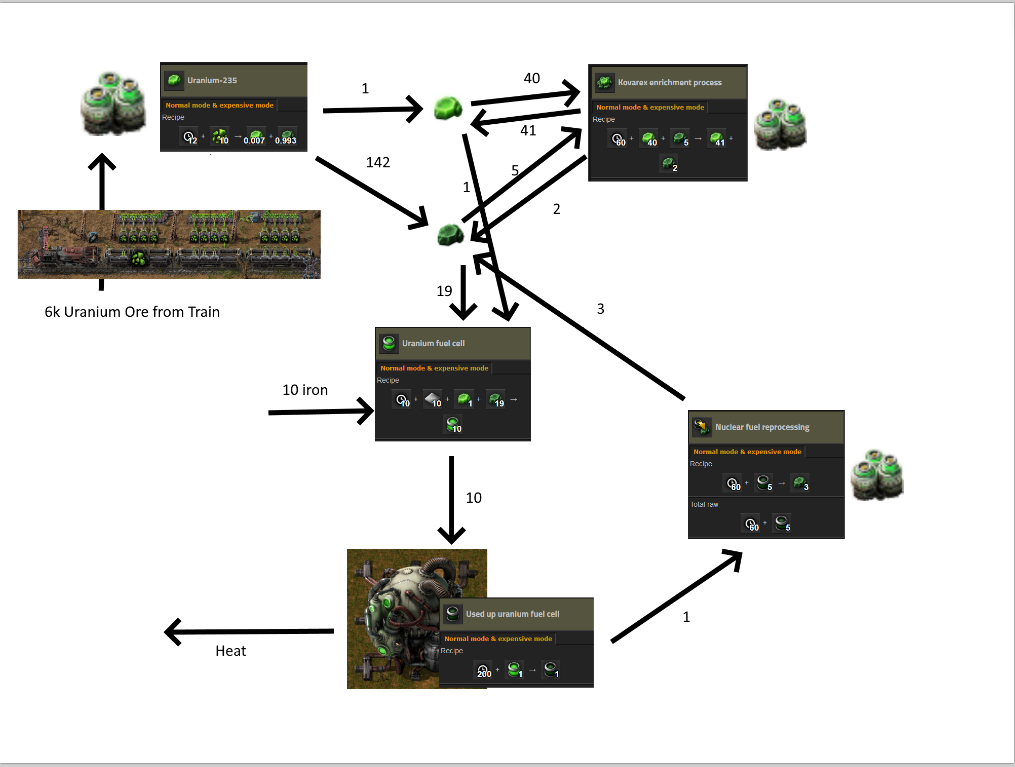

Shown in the above diagram is Factorio's crafting system and my implementation of it.

### Uranium Ore, U-235, U-238, Fuel Cells, and Atomic Bombs

### Train Station for Uranium Ore
The process starts when my train brings in a load of Uranium ore from the Uranium mines. My train can bring in 6k Uranium ore at a time from a source of ~2.3 Million Uranium ore. For the purposes of simplification for this model, let us assume that the train is fast enough to make trips and the mine is deep enough to practically assume that the supply of ore is infinite and there is alway ore available at the station.

### Centrifuge Tasks
After the uranium ore supply, there are 3 tasks that require centrifuges.

1. Refining the uranium ore into U-235 and U-238.
Refining uranium ore into U-235 takes a very long time because 99.3% of the time the ore refines into U-238 and only 0.7% of the time the ore refines into U-235. This leads to an expected (not guaranteed) 1 unit of unranium-235 per approximately 143 processing cycles.
For the purposes of simplification, I will assume that this stochastic probability is actually the guaranteed outcome. As discussed before, this is actually not guaranteed, but I wanted to remove this complexity from the model (at least at first).

2. Enriching U-238 into U-235 via the Kovorex enrichment process.
Enriching U-238 into U-235 is a much faster and 100% guaranteed method of producing U-235. The only downside is this process takes 40 U-235 already, meaning that is effectively requires a 40 U-235 cost per centrifuge working on this task. 

3. Recycling used fuel cells into U-238.
This can just be done with 1 centrifuge within the 200+ second time frame of the system burning through cells within the reactor.

This refining-vs-enriching question is, in my opinion, the most interesting part of this problem: Given a certain amount of time to aquire a certain amount of U-235, is it worth spending 40 U-235 to increase U-235 production rate? i.e. what is the distribution of centrifuges for each task?

I also recognize that there is the possibility of me repurposing the centrifuges from the refining task to the enriching task, but this in itself would take a lot of indeterminate time to redesign of the real layout of the system, so for simplicity's sake, I will consider each assignment of centrifuges permanent. We simply cannot risk inefficient task repurposing for these machines when time is of the essence. We will simply create more centrifuges if we have to.

### Other tasks
Other than that, the other tasks within the diagram are crafting both uranium isotopes into fuel cells to be used in the nuclear reactor to power the factory. For simplification purposes, I will treat this as a slow trickling decrease in U-235 every 2000 seconds.

### A modified diagram
Below shows a modified version of the previous diagram from above. We are able to make some more assumptions in order to simplify it. For example, we can assume that any extra materials such as iron will be easy to acquire, and therefore in effectively inifite supply. Also, we can notice that the U-238 stockpile has a larger amount of input than output. We can then also assume that this supply is also effectively infinite for the tasks that need this resource, so we can also ignore this in the modified diagram.

What that leaves us with is the net flow of U-235, which is the resource we care about the most for nuclear power and atomic bombs anyway.

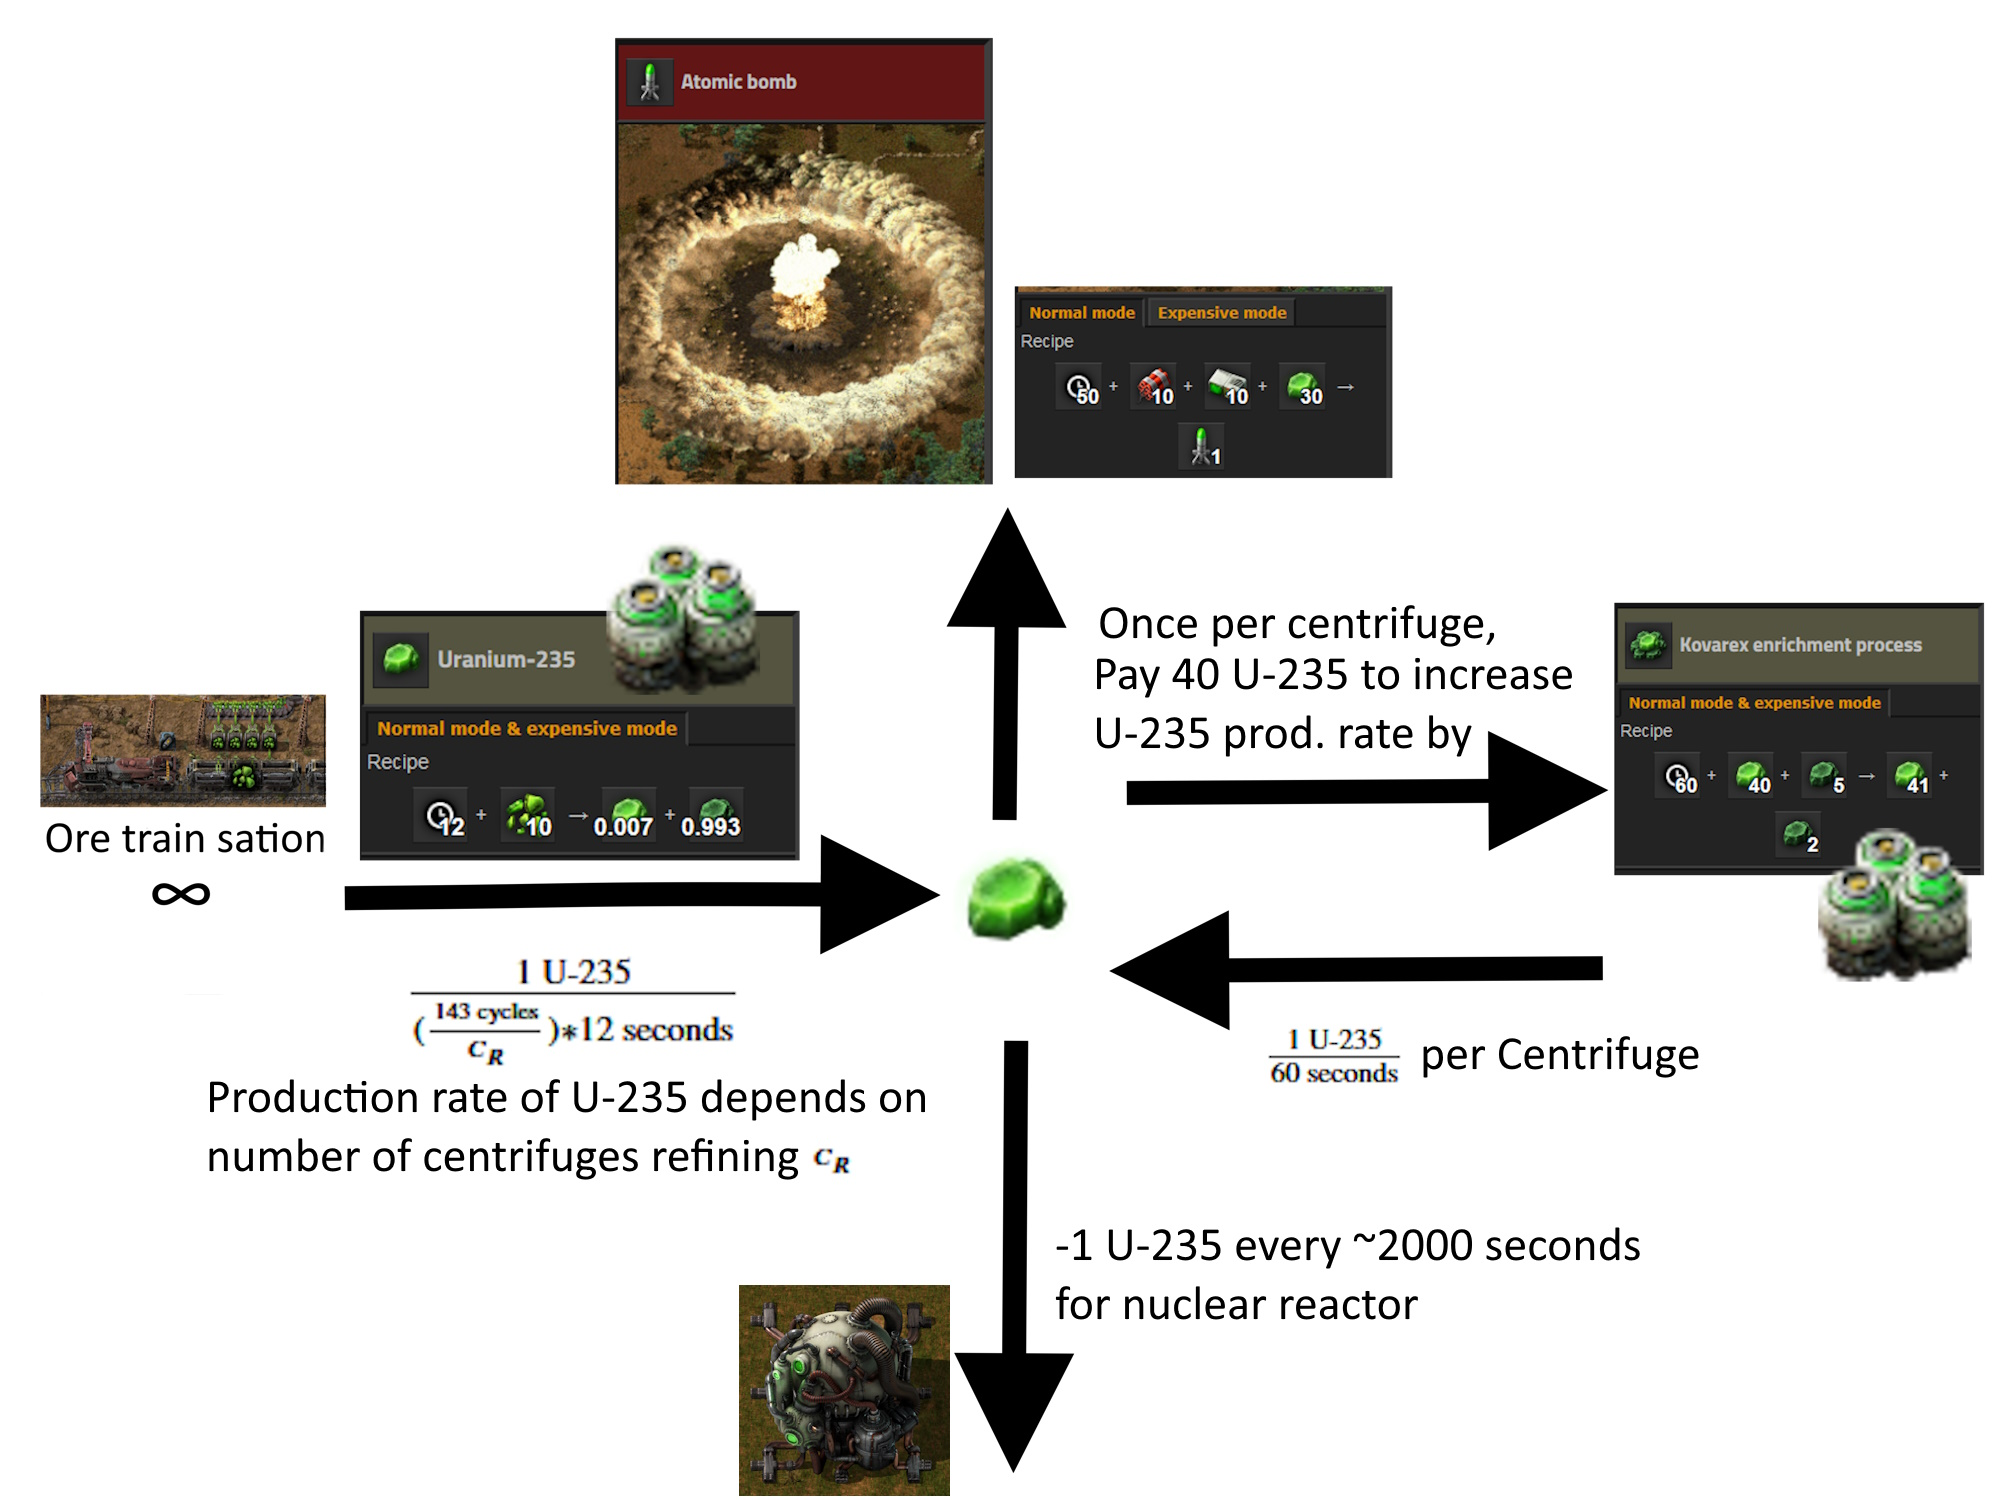

I changed the flow line to instead be the rate of which U-235 is produced at centrifuges (or used up) rather simply the output value of the crafting step. I believe this better shows the flow of U-235 in and out of the stockpile.

I imagine that U-235 would not be taken out of the stockpile to create atomic bombs until the entire refining-enriching process is complete.

### First Glimmer of the Math Model: Some Variables and Data

* $A$ - the amount of atomic bombs requested; $A = 2$
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $U_D$ - the amount of U-235 needed to create the amount of atomic bombs requested; $U_D = 30A$
* $T$ - the total amount of time (seconds) available to get $U_P=U_D$
* $C$ - the total amount of centrifuges; $C = C_R + C_E$ + 1 for the recycling task
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E$ = 40

The above data and variables represent the goal of creating two atomic bombs within a specified time frame. The main question would be how many centrifuges do we need and how many do we need for each task? I could also change the amount of bombs requested and the time from in the experimentation stage to see how different the model behaves in different situations.

### Times and Rates

* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $R_i$ - U-235 production rate with i of the $C_E$ centrifuges active
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$)
* $R_P$ - the decrease in U-235 supply from the nuclear power plant
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.

A few more variables are needed in order to fully model the rate in which U-235 is produced. To motivate the need for more variables, I will point out that we cannot use the enrichment process until we reach 40 U-235. This means that there is an initial period of time where only $C_R$ centrifuges are running the refinement task and 0 centrifuges are running the enrichment task, so thae rate of production is equal to the $C_R$ production rate $R_0$. After we reach this 40 threshold, there is an increase in the total production rate of U-235 by $R_E$. If this 40 U-235 theshold is met again after another amount of time, we can choose to increase the total production rate again by $R_E$.

These different rates in different time periods must be accounted for in order to determine how much net U-235 is produced at the end of the total time period $T$. Below is a visual diagram (explanation purpose only, not to scale) of the rates over different time periods. This assumes that we do buy 2 $C_E$'s help.

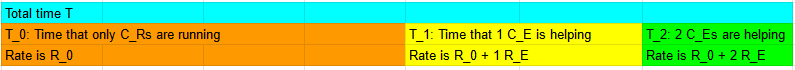

The rate in $T_i$ that is $R_0 + i R_E$ would could call $R_i$. I will use that here for sake of ease of explanation, but it will not be used in my model later because I will be using an alternative form that allows for the constraints to be simpler (that alternate form will also be listed in this explanation).

We can multiply each time period $T_i$ by its respective rate $R_i$ in order to get the amount of U-235 produced in each time period. If we add these all together, we get the total amount of U-235 produced $U_P^*$

$T_0 R_0 + T_1 R_1 + ... + T_{C_E} R_{C_E} = U_P^*$

or alternatively,

$\sum_{i=0}^{C_E}T_i(R_0+iR_E) = U_P^*$

I do have an asterisk here, and that is to point out that we still need to pay the $P_E=40$ U-235 cost as well as the cost to maintain the nuclear reactor's power $R_P$, so the real $U_P$ is:

$T_0 R_0 + T_1 R_1 + ... + T_{C_E} R_{C_E} - P_EC_E - TR_P= U_P$

or alternatively,

$\sum_{i=0}^{C_E}T_i(R_0+iR_E) - P_EC_E - TR_P= U_P$

### Determining base prod rate $R_0$

$R_0$ is a function of $C_R$. The production rate of $C_R$ refining centrifuges is $C_R$ U-235 per 143 cycles, which takes 12 seconds per cycle. A larger $C_R$ means that the centrifuges are running in parallel and the cycles are divided amongst them evenly.

$R_0 = C_R \cdot \frac{1\text{ U-235}}{143\text{ cycles}*12\text{ seconds}}$

Just for the sake of replacing data with variables, I will also define:

* $T_{C_R}$ - time it takes for 1 $C_R$ cycle; $T_{C_R} = 12$ seconds
* $N_R$ - number of cycles needed to produce 1 U-235; $N_R = 143$

So:

$R_0 = C_R \cdot \frac{1\text{ U-235}}{N_R*T_{C_R}\text{ seconds}}$

Remember, $N_R = 143$ is just an assumption based on the expected value of a probability. I could increase this value to increase the likelihood of $N_R$ being more accurate, and by extension the entirety of the model. I could experiment with this value in order to increase the percent confidence that we have in the system.

## Putting it all together: The Model

This model ended up being a nonlinear quadratic program. I originally thought that this would be a MIP because of the integer valued resources, but the complexity of the model including a couple nonlinear constraints forced me to loosen the integer constraints.

# NOTE: I discovered some issues with my earlier models, so the code below is for demonstrational purposes of these issues. These code implementations do not yet work as intended. See later sections (Model 3.0 and beyond) for working code...

Here are all the variables and data values relisted and reogranized, as well as the objective function and constraints. We want to minimize the amount of centrifuges $C$ needed to produce a certain amount of bombs within a time limit. We also want to get the optimal task assignment of the centrifuges.

#### Data
* $A$ - the amount of atomic bombs requested; $A = 2$
* $U_D$ - the demanded amount of U-235 needed to create the amount of atomic bombs requested; $U_D = 30A$
* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E$ = 40
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 60\text{ seconds}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 2000\text{ seconds}$
* $T$ - the total amount of time (seconds) available to get $U_P$
* $T_{C_R}$ - time it takes for 1 $C_R$ cycle; $T_{C_R} = 12$ seconds
* $N_R$ - number of cycles needed to produce 1 U-235; $N_R = 143$

#### Variables
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $C$ - the total amount of centrifuges; $C = C_R + C_E$ + 1 for the recycling task
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.

#### Objective and Constraints

$\min C = C_R + C_E + 1$

s.t.

$\sum_{i=0}^{C_E} T_i \leq T$

$R_0 = C_R \cdot \frac{1}{N_R T_{C_R}}$

$\sum_{i=0}^{C_E}T_i(R_0+iR_E) - P_EC_E - TR_P= U_P$

$U_P \geq U_D$

$U_P, C, C_R, C_E, R_0, T_0 \geq 0$

$\forall i \in \{1, C_E\}, T_i \geq 0$

In [3]:
# using JuMP, Clp

# # Data
# A = 2
# U_D = 30 * A
# P_E = 40
# R_E = 1/60.0
# R_P = 1/2000.0
# T = 1000 # TODO total amount of seconds available
# T_C_R = 12 # seconds
# N_R = 143

# # Create a new model
# m = Model()

# # Define variables
# @variable(m, U_P >= 0)
# @variable(m, C >= 0)
# @variable(m, C_R >= 0)
# @variable(m, C_E >= 0)
# @variable(m, R_0 >= 0)
# @variable(m, T_0 >= 0)
# # TODO create a bunch of Ti variables

# # Define objective
# @objective(m, Min, C)

# # Define constraints
# @constraint(m, centrifuges, C == C_R + C_E + 1)
# #@constraint(m, time, all time <= T) # TODO
# @constraint(m, base_rate, R_0 == C_R * (1/(N_R * T_C_R)))
# #@constraint(m, u_prod, sum i=0 C_E T[i](R_0 + i*R_E) - P_E*C_E - T*R_P = U_P) # TODO sum
# @constraint(m, u_demand, U_P >= U_D)
# ; #suppress output

# set_optimizer(m, Clp.Optimizer)

# @time(optimize!(m))

# println("U_P: ", value(U_P))
# println("C: ", value(C))
# println("C_R: ", value(C_R))
# println("C_E: ", value(C_E))
# println("R_0: ", value(R_0))
# println("T_0: ", value(T_0))
                        
# println("objective: ", objective_value(m))

### An alternative optimization model to answer a slightly different question:

As an alternative, let's say we have a set amount of centrifuges, let's say $C = 100$. Now what is the minimum time in order to create the required amount of U-235? Still will need to determine optimal task assignment of centrifuges.

#### Data
* $A$ - the amount of atomic bombs requested; $A = 2$
* $C$ - the total amount of centrifuges; $C = C_R + C_E$ + 1 for the recycling task
* $U_D$ - the amount of U-235 needed to create the amount of atomic bombs requested; $U_D = 30A$
* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E$ = 40
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 60\text{ seconds}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 2000\text{ seconds}$
* $T_{C_R}$ - time it takes for 1 $C_R$ cycle; $T_{C_R} = 12$ seconds
* $N_R$ - number of cycles needed to produce 1 U-235; $N_R = 143$

#### Variables
* $T$ - the total amount of time (seconds) to get $U_P$
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.

#### Objective and Constraints

$\min T$

s.t.
$C = C_R + C_E + 1$

$\sum_{i=0}^{C_E} T_i \leq T$

$R_0 = C_R \cdot \frac{1}{N_R T_{C_R}}$

$\sum_{i=0}^{C_E}T_i(R_0+iR_E) - P_EC_E - TR_P= U_P$

$U_P \geq U_D$

$U_P, C, C_R, C_E, R_0, T_0 \geq 0$

$\forall i \in \{1, C_E\}, T_i \geq 0$

In [4]:
# using JuMP, Clp

# # Data
# A = 2
# C = 100
# U_D = 30 * A
# P_E = 40
# R_E = 1/60.0
# R_P = 1/2000.0
# T_C_R = 12 # seconds
# N_R = 143

# # Create a new model
# m = Model()

# # Define variables
# @variable(m, T >= 0)
# @variable(m, U_P >= 0)
# @variable(m, C_R >= 0)
# @variable(m, C_E >= 0)
# @variable(m, R_0 >= 0)
# #@variable(m, T_0 >= 0)
# # TODO create a bunch of Ti variables

# # Define objective
# @objective(m, Min, T)

# # Define constraints
# @constraint(m, centrifuges, C == C_R + C_E + 1)
# #@constraint(m, time, all time <= T) # TODO
# @constraint(m, base_rate, R_0 == C_R * (1/(N_R * T_C_R)))

# #@constraint(m, u_prod, sum i=0 C_E T[i](R_0 + i*R_E) - P_E*C_E - T*R_P = U_P) # TODO sum
# #@constraint(m, u_prod_R, T * R_0 == U_P)

# @constraint(m, u_demand, U_P >= U_D)
# ; #suppress output

# set_optimizer(m, Clp.Optimizer)

# @time(optimize!(m))

# println("U_P: ", value(U_P))
# println("T: ", value(T))
# println("C_R: ", value(C_R))
# println("C_E: ", value(C_E))
# println("R_0: ", value(R_0))
# println("T_0: ", value(T_0))
                        
# println("objective: ", objective_value(m))

### One last alternative model for another form of the question:

As one last alternative, let's say we have a set amount of centrifuges, let's say $C = 100$ and a given time limit. What is the most amount of U-235 $U_P$ (and by extension, atomic bombs A) we can create in that time period?

#### Data
* $C$ - the total amount of centrifuges; $C = C_R + C_E$ + 1 for the recycling task
* $T$ - the total amount of time (seconds) to get $U_P=U_N$
* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E$ = 40
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 60\text{ seconds}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 2000\text{ seconds}$
* $T_{C_R}$ - time it takes for 1 $C_R$ cycle; $T_{C_R} = 12$ seconds
* $N_R$ - number of cycles needed to produce 1 U-235; $N_R = 143$

#### Variables
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.

#### Objective and Constraints

$\max U_p$

s.t.
$C = C_R + C_E + 1$

$\sum_{i=0}^{C_E} T_i \leq T$

$\sum_{i=0}^{C_E}T_i(R_0+iR_E) - P_EC_E - TR_P= U_P$

$R_0 = C_R \cdot \frac{1}{N_R T_{C_R}}$

$U_P, C, C_R, C_E, R_0, T_0 \geq 0$

$\forall i \in \{1, C_E\}, T_i \geq 0$

In [5]:
# using JuMP, Ipopt

# # Data
# A = 2
# C = 2
# U_D = 40
# P_E = 40
# R_E = 1/60.0
# R_P = 1/2000.0
# T_C_R = 12 # seconds
# N_R = 143 #142.85714285714284

# # Create a new model
# m = Model()

# # Define variables
# @variable(m, T >= 0)
# @variable(m, U_P >= 0)
# @variable(m, C_R >= 0)
# @variable(m, C_E >= 0)
# @variable(m, R_0 >= 0)
# @variable(m, T_0 >= 0)
# @variable(m, T_[1:C] >= 0)

# @variable(m, z[1:C] >= 0)

# @constraint(m, blah[i in 1:C], z[i] <= 1)

# # Define objective
# @objective(m, Min, T)

# # Define constraints
# @constraint(m, centrifuges, C == C_R + C_E)

# @constraint(m, c_e, C_E == 1)

# @constraint(m, centrifuges_R, C_R >= 1)
# @constraint(m, centrifuge_R_time, T_0 >= T_C_R)

# @constraint(m, base_rate, R_0 == C_R * (1/(N_R * T_C_R)))
# @constraint(m, u_demand, U_P >= U_D)

# @constraint(m, sum(z[i] for i in 1:C) == C_E)

# @constraint(m, time_total, T_0 + sum(z[i]*T_[i] for i in 1:C) <= T)
# @NLconstraint(m, u_prod, T_0*R_0 + sum(z[i]*T_[i]*(R_0 + sum(z[j] for j in 1:i)*R_E) for i in 1:C-1) - P_E*C_E == U_P )

# # Old stuff that didn't quite work
# # @constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C) <= T) # TODO
# # @NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C ) - P_E*C_E - T*R_P == U_P ) # TODO sum

# #@constraint(m, time_total, T_0 + T_[1] <= T) # TODO
# #@NLconstraint(m, u_prod, T_0*R_0 + T_[1]*(R_0 + C_E*R_E) - P_E*C_E - T*R_P == U_P ) # TODO sum

# #@constraint(m, u_prod_R, T * R_0 == U_P)

# ; #suppress output

# set_optimizer(m, Ipopt.Optimizer)

# @time(optimize!(m))

# println("U_P: ", value(U_P))
# println("C_R: ", value(C_R))
# println("C_E: ", value(C_E))
# println("R_0: ", value(R_0))

# println("T 0: ", value(T_0))
# for t in 1:C
#     if value(T_[t]) > 0.1
#         println("T ", t, ": ", value(T_[t]))
#     end
# end

# for t in 1:C
#     println("Z ", t, ":", value(z[t]))
# end
                        
# println("objective: ", objective_value(m))

### First Experiements reveal some unconsidered edge cases

My first experiements writing code in Julia above revealed some things that I did not consider about this current model.

1. There is nothing tying each $C_E$ to a time period $T_i$
2. The $U_P$ constraint is nonlinear, so not all solvers can solve it
3. The video game has every resource in integer values, but I have no constraints to force integer values to make this an Integer Program. For example, the centrifuges work on cycles, so they only give integer outputs. Running a refinging centrifuge for 12 seconds will give 1 output, and running a centrifuge for 18 seconds will not give 1.5 outputs, it will still give 1. The model is trying to run centrifuges for lengths of time that are not multiples of the lengths of their cycles. It also tries to give fractional amounts of uranium, of which Factorio only counts these resources in integer values.
4. I have no constraints to prevent a negative amount of U-235 in the stockpile at any given instant. This is causing the solver to do a few weird things, such as put all centrifuges on enriching without ever having any assigned to refining, and therefore no U-235 from refining in the first place.
5. I am using variable $C_E$ within a a couple summations, and I am unsure if it is possible to tell Julia/JuMP to have an amount of variables that is dependent on the value of one of the variables.

#### What am I going to do about it?

To solve both 1 and 5, I will modify my model to have a maximum amount of centrifuges available. I will treat this problem like a General Assignment Problem and use indicator $z_i$ variables to assign centrifuges to tasks.

For 2, I will have to stay within the abilities of a model that can solve NL programs because this constraint is very important.

I do not think I will modify my model in a way to solve all of elements of issue 3. I realize that we have learned strategies to deal with integer values and such, but I am deciding to keep these constraints loose in order to make the problem easier to solve. I accept that non-integer values will be "good enough" because I want to focus on solving other issues that I find far more interesting and still complex issues to resolve.

However, I do have an idea to solve some parts of issue 3 and to solve issue 4. I will implement a system of time instances and cycles that will divide time up into 12 second segments based on the length of a refining centrifuge cycle. My rates will be re-defined in terms of these cycles instead of seconds. This solves the problem of the model trying to produce fractional output. I will also guarantee that the uranium stockpile is always positive at every given moment to prevent the model from trying to cheat.

### Model 2.0

This model answers the question "What is the maximum amount of U-235 we can make with C centrifuges in time limit T?" The model still attempts to figure out the task assignment of the centrifuges itself.

I think that the z indicators effectively solve my problem of the enrichment centrifuges not being properly linked to the time periods that they should correspond to.

This model, however, still has the problem of cheating and allowing negative amounts of uranium.

#### Data
* $C$ - the total amount of centrifuges; $C = C_R + C_E$ + 1 for the recycling task
* $T$ - the total amount of time (cycles) to get $U_P$
* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E = 40$
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 60\text{ seconds}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 2000\text{ seconds}$
* $T_{C_R}$ - time it takes for 1 $C_R$ cycle; $T_{C_R} = 12$ seconds
* $N_R$ - number of cycles needed to produce 1 U-235; $N_R = 143$

#### Variables
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C-1\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.
* $z_{i \in \{1,C-1\}}$ - indicator variable that the i-th centrifuge is assigned to enriching.

#### Objective and Constraints

$\max U_P$

s.t.
$C = C_R + C_E + 1$

$T_0 + \sum_{i=1}^{C-1} z_i T_i \leq T$

$T_0 R_0 + \sum_{i=1}^{C-1}z_i T_i(R_0 + (\sum_{j=1}^i z_j) R_E) - P_EC_E - T R_P= U_P$

$R_0 = C_R \cdot \frac{1}{N_R T_{C_R}}$

$U_P, C, C_R, C_E, R_0, T_0 \geq 0$

$\forall i \in \{1, C-1\}, T_i \geq 0$

$\forall i \in \{1, C-1\}, z_i \in \{0,1\}$

### Model 3.0: Final Form

Below is another attempt at the model, and I think this is my favorite version yet. 

I realized a new problem with model 2.0. There are not solvers available to me that will be able to handle both binary variables and non-linear constraints. I will have to figure out how to remove either the binary z variables that I just added, or turn the non-linear constraint into a linear constraint. Turning the non-linear constraint into a linear one seems extremely difficult and would require some sacrifices, so I am going to do my best to find an alternative solution to my binary z variables, which I have removed altogether.

I attempted a solution to the negative amounts of uranium stockpile to implement $T$ instance variables $I_t$ to represent the stockpile size at any given instant (I wanted to guarantee this is always $\geq 0$). This proved to be a poor solution for a few reasons: 1. this creates $T$ variables, and $T$ is usually quite large, so that is a lot of variables. 2. $T$ is also a variable itself, so the amount of variables is not determined beforehand. This becomes a similar issue to the $C_E$ within the summation that I had before. 3. It became clear very quickly that determining the value of $I_t$ at every instance $t$ was going to be complicated in itself, because the rate is different over different time periods.

I realized that I can make an assumption that if we do want to use enrichment centrifuges, we want to use them as early as possible. Using this assumption, I can actually calculate the minimum values of $T_0$ and $T_{i \in \{1, C_E-1\}}$, with $T_{C_E}$ being the leftover amount of $T$ to get to $U_P$. The uranium stockpile will never go negative if the time values are at least these calculated sizes.

I needed to give up on the solver being able to figure out the distribution of centrifuges all by itself and help it out a little bit with a brute force method. The solver doesn't actually take a lot of time to solve an instance of the model, so I think I can loop through every possibility of distribution of centrifuges and just pick the one that comes out to be the most optimal. I actually figured out that if I assign $C_E$, it still can figure out $C_R$ on its own, which I like. I also needed to constrain $C_R \geq 1$ because it would cheat otherwise and use all $C_E$ (we cannot enrich to get more U-235 without already having some U-235 via refinement).

I also changed the time periods to be measured in cycles rather than seconds. I am also able to swap out $N_R$ with $R_R$ because it is slightly more accurate to just say that we make 0.007 U-235 every cycle than we make 1 U-235 every 143 cycles. Note that $R_R = 1/N_R$. I am loosening the constraint that we deal with integer values because it makes solving the problem easier, and if, for example, we make 14.54 uranium, then we know to always round down to 14 and it was 54% of the way done with one more.

The model solution outputs the number of centrifuges in decimal form, but a reminder that this is just the minimum amount needed. We know that we should always round up to get to the nearest full number of centrifuges.

#### Data
* $A$ - the amount of atomic bombs requested; $A = 2$
* $U_D$ - the amount of U-235 demanded to create the amount of atomic bombs requested; $U_D = 30A$

* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* ${C_E}_{max}$ - the max amount of centrifuges assigned to the Enrichment task. $C_E$ will cycle from $0$ to ${C_E}_{max}$

* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E  = 40$
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 5\text{ cycles}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 167\text{ cycles}$

* $T_{cycle}$ - time defined as 1 cycle; $T_{cycle} = 12$ seconds
* $R_R$ - amount of U-235 created in 1 cycle with refining; $R_R = 0.007$

* $T$ - the total amount of time (in cycles)

#### Variables
* $C$ - the total amount of centrifuges; $C = C_R + C_E + 1$
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.

#### Objective and Constraints

$\min C$

s.t.
$C = C_R + C_E + 1$

$C_R >= 1$

$\sum_{i=0}^{C_E} T_i \leq T$

$R_0 = C_R R_R$

$\sum_{i=0}^{C_E} T_i(R_0 + i R_E) - P_EC_E - TR_P = U_P$

$P_E/R_0 \leq T_0$

$\forall i \in \{1, C_E-1\}, P_E/(R_0+iR_E) \leq T_i$

$U_P \geq U_D$

$C, C_R, U_P, R_0 \geq 0$

$\forall i \in \{0, C_E\}, T_i \geq 0$

In [6]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E_max = 50

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
R_R = 0.007

T = 300

for C_E in 0:C_E_max

    # Create a new model
    m = Model()
    set_silent(m)
    
    # Define variables
    @variable(m, C >= 0)
    @variable(m, C_R >= 0)
    @variable(m, U_P >= 0)
    @variable(m, R_0 >= 0)
    @variable(m, T_0 >= 0)
    
    if C_E >= 1
        @variable(m, T_[1:C_E] >= 0)
    end
    #@variable(m, T >= 0)

    # Define objective
    @objective(m, Min, C)

    # Define constraints
    @constraint(m, centrifuges, C == C_R + C_E + 1)

    @constraint(m, min_C, C_R >= 1)

    @constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

    @NLconstraint(m, P_E/R_0 <= T_0)

    @NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

    @constraint(m, base_rate, R_0 == C_R * R_R)
    
    @constraint(m, u_demand, U_P >= U_D)

    @NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )

    set_optimizer(m, Ipopt.Optimizer)
    ; #suppress output

    @time(optimize!(m))

    println("C_R: ", value(C_R))
    println("C_E: ", value(C_E))
    println("U_P: ", value(U_P))
    println("R_0: ", value(R_0))

    println("T 0: ", value(T_0))
    for t in 1:C_E
        if value(T_[t]) > 0.1
            println("T ", t, ": ", value(T_[t]))
        end
    end
    println("T : ", value(T))

    println("objective: ", objective_value(m))

    println()
    println()
    println()
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

  1.375886 seconds (1.23 M allocations: 82.777 MiB, 2.02% gc time, 98.97% compilation time: 92% of which was recompilation)
C_R: 29.42685998961331
C_E: 0
U_P: 59.999999405261
R_0: 0.20598801992729315
T 0: 300.00000297445143
T : 300
objective: 30.42685998961331



  0.010764 seconds (1.92 k allocations: 81.297 KiB)
C_R: 35.31390937828576
C_E: 1
U_P: 59.99999940755889
R_0: 0.2471973656480003
T 0: 161.81402217622824
T 1: 138.18598080686897
T : 300
objective: 37.31390937828576



  0.009904 seconds (1.70 k allocations: 81.844 KiB)
C_R: 43.17463638896617
C_E: 2
U_P: 59.99999940889052
R_0: 0.3022224547227632
T 0

  0.009986 seconds (3.08 k allocations: 254.672 KiB)
C_R: 207.40471462195907
C_E: 22
U_P: 60.00000806942627
R_0: 1.4518330023537136
T 0: 27.551380070031744
T 1: 24.21552501742849
T 2: 21.600222020140222
T 3: 19.49476619915199
T 4: 17.763308983604144
T 5: 16.314327357875296
T 6: 15.083908799050144
T 7: 14.026069611971899
T 8: 13.106880156216814
T 9: 12.300757997542343
T 10: 11.588049713623542
T 11: 10.95340732401728
T 12: 10.384670527935205
T 13: 9.872079982388527
T 14: 9.407712620282252
T 15: 8.985069184327877
T 16: 8.598768171710415
T 17: 8.24431549781019
T 18: 7.917928933213863
T 19: 7.616402847069993
T 20: 7.33700355266754
T 21: 7.077393284272793
T 22: 10.560053666178867
T : 300
objective: 230.40471462195907



  0.010784 seconds (3.15 k allocations: 261.609 KiB)
C_R: 215.6145209064255
C_E: 23
U_P: 60.000008083100205
R_0: 1.5093016463449784
T 0: 26.502325052633406
T 1: 23.401371806801045
T 2: 20.95007041175397
T 3: 18.963624584960378
T 4: 17.32125611092441
T 5: 15.940692537118897
T 

  0.030243 seconds (4.10 k allocations: 342.016 KiB, 32.12% gc time)
C_R: 297.70170407222656
C_E: 33
U_P: 59.99999941191915
R_0: 2.083911928505586
T 0: 19.19466913921313
T 1: 17.513810179006004
T 2: 16.10363053572578
T 3: 14.903618689442137
T 4: 13.870049075255567
T 5: 12.9705390111799
T 6: 12.180594621674933
T 7: 11.481346484641016
T 8: 10.858022870315763
T 9: 10.298894698726102
T 10: 9.7945305065332
T 11: 9.337260110928398
T 12: 8.920781809650103
T 13: 8.539870214827044
T 14: 8.190155873412593
T 15: 7.867956905726938
T 16: 7.570148879638361
T 17: 7.294063159122861
T 18: 7.03740671369976
T 19: 6.798198282408193
T 20: 6.574717128897794
T 21: 6.365461582444773
T 22: 6.169115251926101
T 23: 5.984519305588383
T 24: 5.810649582994874
T 25: 5.646597584164294
T 26: 5.491554590690998
T 27: 5.344798332959956
T 28: 5.205681739577933
T 29: 5.07362339931731
T 30: 4.948099439171444
T 31: 4.828636580063191
T 32: 4.714806183497466
T 33: 7.116194536205163
T : 300
objective: 331.70170407222656



  0.

  0.014504 seconds (4.91 k allocations: 463.688 KiB)
C_R: 379.778149332664
C_E: 43
U_P: 60.00000822511984
R_0: 2.658447045328648
T 0: 15.046379340325347
T 1: 13.993613433855897
T 2: 13.078533866149742
T 3: 12.275787516196862
T 4: 11.565885888538938
T 5: 10.933602076388636
T 6: 10.366866278762622
T 7: 9.855987890667818
T 8: 9.393096802724658
T 9: 8.97173507612266
T 10: 8.586553800709545
T 11: 8.233084826861091
T 12: 7.907566648706242
T 13: 7.606810021543051
T 14: 7.328093122293147
T 15: 7.069078943524331
T 16: 6.827749607859876
T 17: 6.602353692773046
T 18: 6.391363655374972
T 19: 6.193441167817737
T 20: 6.007408700034319
T 21: 5.832226074562147
T 22: 5.666971007270537
T 23: 5.510822865199832
T 24: 5.363049037644351
T 25: 5.222993442773407
T 26: 5.090066789350226
T 27: 4.9637382886499575
T 28: 4.84352857075755
T 29: 4.729003605938442
T 30: 4.619769468626691
T 31: 4.515467810954388
T 32: 4.415771936316977
T 33: 4.320383382514774
T 34: 4.229028939551159
T 35: 4.141458040074892
T 36: 4.057

Here is another final version: the previous had $T$ is assigned beforehand and this one has $T$ is included within the minimizing objective function. This becomes a multi-objective problem, and just adding the values together is probably not the best way to do it. However, I was very curious to see how it would behave to find the min amount of $C$ to complete the task in the least amount of time $T$.

#### Data
* $A$ - the amount of atomic bombs requested; $A = 2$
* $U_D$ - the amount of U-235 demanded to create the amount of atomic bombs requested; $U_D = 30A$

* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* ${C_E}_{max}$ - the max amount of centrifuges assigned to the Enrichment task. $C_E$ will cycle from 0 to ${C_E}_{max}$

* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E$ = 40
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 5\text{ cycles}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 167\text{ cycles}$
* $T_{cycle}$ - time defined as 1 cycle; $T_{cycle} = 12$ seconds
* $R_R$ - amount of U-235 created in 1 cycle with refining; $R_R = 0.007$

#### Variables
* $C$ - the total amount of centrifuges; $C = C_R + C_E + 1$
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.
* $T$ - the total amount of time (in cycles)

#### Objective and Constraints

$\min C + T$

s.t.
$C = C_R + C_E + 1$

$C_R >= 1$

$\sum_{i=0}^{C_E} T_i \leq T$

$R_0 = C_R R_R$

$\sum_{i=0}^{C_E} T_i(R_0 + i R_E) - P_EC_E - TR_P = U_P$

$T_0 \geq P_E/R_0$

$\forall i \in \{1, C_E-1\}, T_i \geq P_E/(R_0+iR_E)$

$U_P \geq U_D$

$C, C_R, U_P, R_0, T \geq 0$

$\forall i \in \{0, C_E\}, T_i \geq 0$

In [7]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E_max = 50

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
R_R = 0.007

#T = 300

for C_E in 0:C_E_max

    # Create a new model
    m = Model()
    set_silent(m)

    # Define variables
    @variable(m, C >= 0)
    @variable(m, C_R >= 0)
    @variable(m, U_P >= 0)
    @variable(m, R_0 >= 0)
    @variable(m, T_0 >= 0)
    
    if C_E >= 1
        @variable(m, T_[1:C_E] >= 0)
    end
    @variable(m, T >= 0)

    # Define objective
    @objective(m, Min, C + T)

    # Define constraints
    @constraint(m, centrifuges, C == C_R + C_E + 1)

    @constraint(m, min_C, C_R >= 1)

    @constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

    @NLconstraint(m, P_E/R_0 <= T_0)

    @NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

    @constraint(m, base_rate, R_0 == C_R * R_R)
    @constraint(m, u_demand, U_P >= U_D)

    @NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )
    ; #suppress output

    set_optimizer(m, Ipopt.Optimizer)

    @time(optimize!(m))

    println("C: ", value(C))
    println("C_R: ", value(C_R))
    println("C_E: ", value(C_E))
    println("U_P: ", value(U_P))
    println("R_0: ", value(R_0))

    println("T 0: ", value(T_0))
    for t in 1:C_E
        if value(T_[t]) > 0.1
            println("T ", t, ": ", value(T_[t]))
        end
    end
    println("T : ", value(T))

    println("objective: ", objective_value(m))
end

  0.025349 seconds (3.30 k allocations: 119.969 KiB)
C: 94.43744150990359
C_R: 93.43744150990359
C_E: 0
U_P: 59.999999401623896
R_0: 0.6540620905693252
T 0: 92.5820095143794
T : 92.58200950686232
objective: 187.0194510167659
  0.008468 seconds (1.43 k allocations: 68.125 KiB)
C: 107.63455220585061
C_R: 105.63455220585061
C_E: 1
U_P: 59.999999400848466
R_0: 0.7394418654409542
T 0: 54.094854328932136
T 1: 64.62442812623911
T : 118.7192824460745
objective: 226.35383465192513
  0.008532 seconds (1.51 k allocations: 76.953 KiB)
C: 118.51263632110202
C_R: 115.51263632110202
C_E: 2
U_P: 59.999999403013604
R_0: 0.8085884542477142
T 0: 49.46892301995679
T 1: 39.65938717288483
T 2: 50.335672872839
T : 139.4639830581741
objective: 257.97661937927614
  0.008284 seconds (1.54 k allocations: 87.781 KiB)
C: 127.48843369237585
C_R: 123.48843369237585
C_E: 3
U_P: 60.00000209058425
R_0: 0.8644190358466309
T 0: 46.27385817369682
T 1: 37.57919184189031
T 2: 31.63509553779149
T 3: 41.61425489024553
T : 157

  0.012015 seconds (3.20 k allocations: 253.375 KiB)
C: 196.2119137017709
C_R: 174.2119137017709
C_E: 21
U_P: 59.999999413383
R_0: 1.2194833959123963
T 0: 32.80077459503916
T 1: 28.179265855284314
T 2: 24.69923439195938
T 3: 21.984262169383197
T 4: 19.807045736900466
T 5: 18.022211862781297
T 6: 16.53245484309361
T 7: 15.270186498847279
T 8: 14.186996115718394
T 9: 13.247299203738383
T 10: 12.424353558639256
T 11: 11.69767340759804
T 12: 11.051300866584372
T 13: 10.472620468845893
T 14: 9.951527610974258
T 15: 9.47983348876666
T 16: 9.050831607870549
T 17: 8.658976901720836
T 18: 8.299644745909633
T 19: 7.968947585873949
T 20: 7.663593744403931
T 21: 11.427914709320785
T : 322.8769499617554
objective: 519.0888636635262
  0.011865 seconds (3.28 k allocations: 260.781 KiB)
C: 198.35365761684338
C_R: 175.35365761684338
C_E: 22
U_P: 59.99999941385894
R_0: 1.2274756033179035
T 0: 32.587205711869984
T 1: 28.021494656365714
T 2: 24.577941388394077
T 3: 21.88811709211484
T 4: 19.72896735332912

T 28: 5.807763537226999
T 29: 5.643872165296217
T 30: 5.488976755732253
T 31: 5.342356422941945
T 32: 8.100132233324425
T : 378.8247738509921
objective: 595.7294518577498
  0.014063 seconds (4.17 k allocations: 344.344 KiB)
C: 218.5514671365251
C_R: 184.5514671365251
C_E: 33
U_P: 59.99999940716896
R_0: 1.2918602699556756
T 0: 30.963100978294694
T 1: 26.812162500943156
T 2: 23.64261440224352
T 3: 21.143210531229666
T 4: 19.121736072034366
T 5: 17.453070985339334
T 6: 16.052264430983147
T 7: 14.859612299806022
T 8: 13.831926940177095
T 9: 12.937195242096958
T 10: 12.151184039397348
T 11: 11.455212087074278
T 12: 10.83464623374363
T 13: 10.277861278023757
T 14: 9.775504862788054
T 15: 9.319967904276899
T 16: 8.904996496016835
T 17: 8.525403073005497
T 18: 8.176848428897094
T 19: 7.855675105253117
T 20: 7.558778562006047
T 21: 7.283506497846249
T 22: 7.027579396628496
T 23: 6.789027256157474
T 24: 6.566138780401559
T 25: 6.3574202619019795
T 26: 6.161562064643248
T 27: 5.977411117301099
T 

  0.014951 seconds (4.96 k allocations: 459.953 KiB)
C: 232.30676151910933
C_R: 189.30676151910933
C_E: 42
U_P: 60.00001733102785
R_0: 1.3251473306337653
T 0: 30.185324975345296
T 1: 26.22697657879998
T 2: 23.186427697584293
T 3: 20.777632843914045
T 4: 18.82222677745544
T 5: 17.2032133550579
T 6: 15.840662355883472
T 7: 14.678108043474246
T 8: 13.674527523871403
T 9: 12.79939926900224
T 10: 12.02954495110751
T 11: 11.3470463524334
T 12: 10.737833311036331
T 13: 10.190703361224942
T 14: 9.696626559329646
T 15: 9.248243183620009
T 16: 8.83949463654509
T 17: 8.465348083174566
T 18: 8.121588180816927
T 19: 7.804657572999318
T 20: 7.511533327491241
T 21: 7.239630210628289
T 22: 6.986724235524686
T 23: 6.750891693850737
T 24: 6.530460132176122
T 25: 6.323968629107407
T 26: 6.1301353777259235
T 27: 5.947831052603465
T 28: 5.776056792051667
T 29: 5.613925888890363
T 30: 5.460648481146364
T 31: 5.315518684888782
T 32: 5.177903727180162
T 33: 5.047234726831024
T 34: 4.922998840968056
T 35: 4.80

  0.016601 seconds (5.60 k allocations: 520.750 KiB)
C: 243.3913241342871
C_R: 192.3913241342871
C_E: 50
U_P: 59.99999942841883
R_0: 1.3467392689400095
T 0: 29.70136901246152
T 1: 25.860855020788495
T 2: 22.899811493891157
T 3: 20.547178877322363
T 4: 18.63291018331937
T 5: 17.044927194664556
T 6: 15.706358507365252
T 7: 14.562721854938053
T 8: 13.574326172023577
T 9: 12.711571109262078
T 10: 11.951931944519345
T 11: 11.277964616048441
T 12: 10.675949700620418
T 13: 10.134948688017218
T 14: 9.646133354587505
T 15: 9.202300275979974
T 16: 8.797513472299853
T 17: 8.426837394400195
T 18: 8.086134683437548
T 19: 7.771911084270211
T 20: 7.481195165850547
T 21: 7.21144406330723
T 22: 6.9604689024066575
T 23: 6.72637527270616
T 24: 6.507515321863233
T 25: 6.302448907639863
T 26: 6.109911870641766
T 27: 5.92878995018559
T 28: 5.758097206015321
T 29: 5.5969580632011695
T 30: 5.444592289784671
T 31: 5.300302363114529
T 32: 5.163462793186211
T 33: 5.0335110582142875
T 34: 4.909939875378795
T 35: 

### Another Experiment: Confidence levels

As a final experiment, I can reintroduce the $N_R$ variable and look at the confidence curve discussed in the intro section to consider that fact that we are are only going to get 1 U-235 in 143 52% of the time. I implemented a way to edit $N_R$ to affect an implicit confidence/faith parameter to show the percent confidence we want to have in the system's stochastic ability to produce U-235. I edited this value according to the chart below. In all honesty, I am not sure how these values are calculated, but I am trusting them from the Factorio wiki. The "Cycles to get 1" is the previous column divided by 40 rounded up, so they might be slightly inaccurate.

| Confidence level  |	Failures  | 	Cycles required to get 40   |  Cycles required to get 1 |
|--|--|--|--|
| 10% |	9 out of 10  |	4,595     |     115 |
| 50% |	1 out of 2 	 | 5,667     |     142 |
| 90% |	1 out of 10  |	6,894     |     173 |
| 95% |	1 out of 20  |	7,272     |     182 |
| 99% |	1 out of 100 |	8,015      |     201 |


#### Data
* $A$ - the amount of atomic bombs requested; $A = 2$
* $U_D$ - the amount of U-235 demanded to create the amount of atomic bombs requested; $U_D = 30A$

* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* ${C_E}_{max}$ - the max amount of centrifuges assigned to the Enrichment task. $C_E$ will cycle from 0 to ${C_E}_{max}$

* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E$ = 40
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 5\text{ cycles}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 167\text{ cycles}$
* $T_{cycle}$ - time defined as 1 cycle; $T_{cycle} = 12$ seconds
* $N_R$ - amount of U-235 created in 1 cycle with refining; $N_R =$ corresponding value from confidence level chart above.

#### Variables
* $C$ - the total amount of centrifuges; $C = C_R + C_E + 1$
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.
* $T$ - the total amount of time (in cycles)

#### Objective and Constraints

$\min C + T$

s.t.
$C = C_R + C_E + 1$

$C_R >= 1$

$\sum_{i=0}^{C_E} T_i \leq T$

$R_0 = C_R / N_R$

$\sum_{i=0}^{C_E} T_i(R_0 + i R_E) - P_EC_E - TR_P = U_P$

$T_0 \geq P_E/R_0$

$\forall i \in \{1, C_E-1\}, T_i \geq P_E/(R_0+iR_E)$

$U_P \geq U_D$

$C, C_R, U_P, R_0, T \geq 0$

$\forall i \in \{0, C_E\}, T_i \geq 0$

For the example below, let us say we want a 95% confidence. This corresponds to a $N_R$ of 182.

In [8]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E = 10

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
N_R = 182

#T = 300

# Create a new model
m = Model()
set_silent(m)

# Define variables
@variable(m, C >= 0)
@variable(m, C_R >= 0)
@variable(m, U_P >= 0)
@variable(m, R_0 >= 0)
@variable(m, T_0 >= 0)

if C_E >= 1
    @variable(m, T_[1:C_E] >= 0)
end
@variable(m, T >= 0)

# Define objective
@objective(m, Min, C + T)

# Define constraints
@constraint(m, centrifuges, C == C_R + C_E + 1)

@constraint(m, min_C, C_R >= 1)

@constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

@NLconstraint(m, P_E/R_0 <= T_0)

@NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

@constraint(m, base_rate, R_0 == C_R / N_R)
@constraint(m, u_demand, U_P >= U_D)

@NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )
; #suppress output

set_optimizer(m, Ipopt.Optimizer)

@time(optimize!(m))

println("C: ", value(C))
println("C_R: ", value(C_R))
println("C_E: ", value(C_E))
println("U_P: ", value(U_P))
println("R_0: ", value(R_0))

println("T 0: ", value(T_0))
for t in 1:C_E
    if value(T_[t]) > 0.1
        println("T ", t, ": ", value(T_[t]))
    end
end
println("T : ", value(T))

println("objective: ", objective_value(m))

  0.012262 seconds (2.49 k allocations: 161.438 KiB)
C: 176.7440021654507
C_R: 165.7440021654507
C_E: 10
U_P: 59.99999940264063
R_0: 0.9106813305793996
T 0: 43.92315802350589
T 1: 36.01393026896034
T 2: 30.51847848582228
T 3: 26.47811896397844
T 4: 23.382496360739367
T 5: 20.934940508268273
T 6: 18.951226509820767
T 7: 17.310911486454376
T 8: 15.931930310819927
T 9: 14.7564376370766
T 10: 21.16789289043115
T : 269.3695214367847
objective: 446.1135236022354


#### Compare the results above with the original $N_R$ = 143 below:

In [9]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E = 10

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
N_R = 143

#T = 300

# Create a new model
m = Model()
set_silent(m)

# Define variables
@variable(m, C >= 0)
@variable(m, C_R >= 0)
@variable(m, U_P >= 0)
@variable(m, R_0 >= 0)
@variable(m, T_0 >= 0)

if C_E >= 1
    @variable(m, T_[1:C_E] >= 0)
end
@variable(m, T >= 0)

# Define objective
@objective(m, Min, C + T)

# Define constraints
@constraint(m, centrifuges, C == C_R + C_E + 1)

@constraint(m, min_C, C_R >= 1)

@constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

@NLconstraint(m, P_E/R_0 <= T_0)

@NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

@constraint(m, base_rate, R_0 == C_R / N_R)
@constraint(m, u_demand, U_P >= U_D)

@NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )
; #suppress output

set_optimizer(m, Ipopt.Optimizer)

@time(optimize!(m))

println("C: ", value(C))
println("C_R: ", value(C_R))
println("C_E: ", value(C_E))
println("U_P: ", value(U_P))
println("R_0: ", value(R_0))

println("T 0: ", value(T_0))
for t in 1:C_E
    if value(T_[t]) > 0.1
        println("T ", t, ": ", value(T_[t]))
    end
end
println("T : ", value(T))

println("objective: ", objective_value(m))

  0.010256 seconds (2.26 k allocations: 155.016 KiB)
C: 165.47806325380623
C_R: 154.47806325380623
C_E: 10
U_P: 59.999999407698326
R_0: 1.0802661766000434
T 0: 37.02791113876075
T 1: 31.243502893201427
T 2: 27.022167110640865
T 3: 23.805752058502623
T 4: 21.27358375694092
T 5: 19.228308591046314
T 6: 17.541811745294545
T 7: 16.127301329298273
T 8: 14.92389090819183
T 9: 13.88760539116665
T 10: 19.949343435257635
T : 242.03117835080266
objective: 407.50924160460886


### Final Experiment: Realizing it takes time to make centrifuges

I had one last realization that even though things would be very fast if we could materialize enough centrifuges, it actually takes time to create centrifuges too. Here is one last model to include the time it takes to make centrifuges into account for the total time. I will use the raw time of 1000 seconds ( ~84 cycles ) to fabricate each centrifuge from scratch. This does take a significant amount of time so it is probably good to consider.

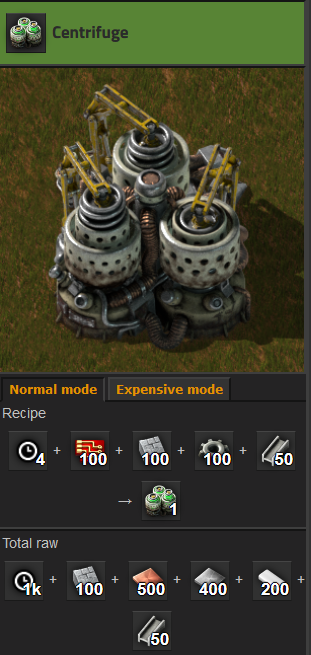

#### Data
* $A$ - the amount of atomic bombs requested; $A = 2$
* $U_D$ - the amount of U-235 demanded to create the amount of atomic bombs requested; $U_D = 30A$

* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* ${C_E}_{max}$ - the max amount of centrifuges assigned to the Enrichment task. $C_E$ will cycle from 0 to ${C_E}_{max}$

* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E$ = 40
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 5\text{ cycles}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 167\text{ cycles}$
* $T_{cycle}$ - time defined as 1 cycle; $T_{cycle} = 12$ seconds
* $N_R$ - amount of U-235 created in 1 cycle with refining; $N_R =$ corresponding value from confidence level chart above.
* $T_{centrifuge}$ - time it takes to create one centrifuge from scratch; $T_{centrifuge} = 84$ cycles.

#### Variables
* $C$ - the total amount of centrifuges; $C = C_R + C_E + 1$
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.
* $T$ - the total amount of time (in cycles)

#### Objective and Constraints

$\min C + T$

s.t.
$C = C_R + C_E + 1$

$C_R >= 1$

$CT_{centrifuge}$ + $\sum_{i=0}^{C_E} T_i \leq T$

$R_0 = C_R / N_R$

$\sum_{i=0}^{C_E} T_i(R_0 + i R_E) - P_EC_E - TR_P = U_P$

$T_0 \geq P_E/R_0$

$\forall i \in \{1, C_E-1\}, T_i \geq P_E/(R_0+iR_E)$

$U_P \geq U_D$

$C, C_R, U_P, R_0, T \geq 0$

$\forall i \in \{0, C_E\}, T_i \geq 0$

In [10]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E = 10

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
N_R = 143

T_centrifuge = 84

#T = 300

# Create a new model
m = Model()
set_silent(m)

# Define variables
@variable(m, C >= 0)
@variable(m, C_R >= 0)
@variable(m, U_P >= 0)
@variable(m, R_0 >= 0)
@variable(m, T_0 >= 0)

if C_E >= 1
    @variable(m, T_[1:C_E] >= 0)
end
@variable(m, T >= 0)

# Define objective
@objective(m, Min, C + T)

# Define constraints
@constraint(m, centrifuges, C == C_R + C_E + 1)

@constraint(m, min_C, C_R >= 1)

@constraint(m, time_total, C*T_centrifuge + T_0 + sum(T_[i] for i in 1:C_E) <= T)

@NLconstraint(m, P_E/R_0 <= T_0)

@NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

@constraint(m, base_rate, R_0 == C_R / N_R)
@constraint(m, u_demand, U_P >= U_D)

@NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )
; #suppress output

set_optimizer(m, Ipopt.Optimizer)

@time(optimize!(m))

println("C: ", value(C))
println("C_R: ", value(C_R))
println("C_E: ", value(C_E))
println("U_P: ", value(U_P))
println("R_0: ", value(R_0))

println("T 0: ", value(T_0))
for t in 1:C_E
    if value(T_[t]) > 0.1
        println("T ", t, ": ", value(T_[t]))
    end
end
println("T_cent : ", value(C*T_centrifuge))
println("T : ", value(T))

println("objective: ", objective_value(m))

  0.019293 seconds (3.07 k allocations: 178.188 KiB)
C: 19.58265079645521
C_R: 8.582650796455209
C_E: 10
U_P: 59.9999994018673
R_0: 0.060018537038148315
T 0: 666.4607631810735
T 1: 153.83518595753426
T 2: 86.9530177055008
T 3: 60.604358437842144
T 4: 46.51062537616416
T 5: 37.73518914409292
T 6: 31.745564699680138
T 7: 27.396912419406146
T 8: 24.09611645814409
T 9: 21.5051620197619
T 10: 37.37878187627218
T_cent : 1644.9426669022375
T : 2839.164344168617
objective: 2858.746994965072


## Analysis and Discussion

For my final analysis, these are the assumptions that I want to make and the model I want to test the most, unless specified otherwise.

#### Assumptions

* $N_R = 143$ or $R_R = 0.007$ is 'good enough'. We will treat the stochastic nature as a guaranteed probability that we will get 1 U-235 every 143 cycles, or a 1:142 ratio of U-235 to U-238.
* The input and output of the U-238 stockpile is net positive so we do not need to worry about this part of the system at all.
* All other resources (including amount of iron, centrifuges, etc) are in infinite and instantaneous supply.
* Supply from the mining station and train station is delivered fast enough to always be able to assume that we have a sufficient supply and delivery rate to meet demand for all centrifuges.
* The conveyor belts and inserter systems can instantaneously deliver uranium and other resources between locations of interest.
* A "cycle" is defined in terms of the time for a centrifuge to process 10 uranium ore into U-235/U-238, which is 12 seconds. Every other unit of time will be measured in terms of multitudes of this base cycle value.
* The nuclear reactor needs 1 U-235 every ~167 cycles. This power is necessary and sufficent to power all centrifuges of the factory. An initial amount of coal and steam power is available to power the processing plant until the nuclear reactor can be powered.
* The nuclear fuel cell recycling plant only requires 1 centrifuge to keep up.
* The atomic bombs will not be crafted until $T$ time has passed.
* Decimal amounts of centrifuges means to round up.
* I also decided to take out the 1 recycling centrifuge here. We know it exists, we can consider the system other than that part.

#### Limitations and sensitivity of assumptions:

* Just using the expected value of ~143 cycles makes the model the most accurate for the average case, but fails to consider the true stochastic nature and therefore is sensitive to be inaccurate for worst case scenarios. 
* This model fails to consider the possibility that resources may run out, and there actually exists a delay between different steps along the process to move along conveyor belts and such. This extraneous time I am considering to be negligible but is still very real and will constribute to the total time.
* It will take time to produce the required amount of centrifuges, but I like this "purer" form of the model, because it is difficult to accurately consider how long crafting these centrifuges will actually take. I already have a lot made, and different components along the way I already have a stockpile, so I would not be starting completely from scratch.
* There are many reasons why the train and mining system may not be able to keep up with demand, such as the 6000 ore limit per train, the time it takes to get between the refining and mining sites, and the fact that in the game there are giant bugs that sometimes attack and destroy parts of the factory.
* I don't know how much I will actually use a nuclear reactor, it was just a fun part to include within the model.
* Rounding cycles of equiptment to the nearest 12 seconds is slightly innaccurate in some cases, and just rounding up decimal value amounts of centrifuges up will make more sense practically, but still produce an inaccurate estimate.

### Here is the base model used for the experiments below

#### Data
* $A$ - the amount of atomic bombs requested; $A = 2$
* $U_D$ - the amount of U-235 demanded to create the amount of atomic bombs requested; $U_D = 30A$

* $C_E$ - the amount of centrifuges assigned to the Enrichment task
* ${C_E}_{max}$ - the max amount of centrifuges assigned to the Enrichment task. $C_E$ will cycle from $0$ to ${C_E}_{max}$

* $P_E$ - the amount of U-235 to pay to use a centrifuge for enrichment ($C_E$); $P_E  = 40$
* $R_E$ - increase amount of U-235 production rate per enriching centrifuge ($C_E$); $R_E = 1\text{ U-235  / } 5\text{ cycles}$
* $R_P$ - the decrease in U-235 supply from the nuclear power plant; $R_P = 1\text{ U-235 / } 167\text{ cycles}$

* $T_{cycle}$ - time defined as 1 cycle; $T_{cycle} = 12$ seconds
* $R_R$ - amount of U-235 created in 1 cycle with refining; $R_R = 0.007$

* $T$ - the total amount of time (in cycles)

#### Variables
* $C$ - the total amount of centrifuges; $C = C_R + C_E$
* $C_R$ - the amount of centrifuges assigned to the Refining task
* $U_P$ - the net amount of U-235 produced in the U-235 stockpile
* $R_0$ - U-235 production rate of $C_R$ centrifuges on their own
* $T_0$ - time period where only $C_R$s are working
* $T_{i \in \{1,C_E\}}$ - time periods where i centrifuges of the total $C_E$ centrifuges are at work.

#### Objective and Constraints

$\min C$

s.t.
$C = C_R + C_E$

$C_R >= 1$

$\sum_{i=0}^{C_E} T_i \leq T$

$R_0 = C_R R_R$

$\sum_{i=0}^{C_E} T_i(R_0 + i R_E) - P_EC_E - TR_P = U_P$

$P_E/R_0 \leq T_0$

$\forall i \in \{1, C_E-1\}, P_E/(R_0+iR_E) \leq T_i$

$U_P \geq U_D$

$C, C_R, U_P, R_0 \geq 0$

$\forall i \in \{0, C_E\}, T_i \geq 0$

In [11]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E_max = 10

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
R_R = 0.007

T = 600

# Results
C_data = zeros(C_E_max+1)

for C_E in 0:C_E_max

    # Create a new model
    m = Model()
    set_silent(m)
    
    # Define variables
    @variable(m, C >= 0)
    @variable(m, C_R >= 0)
    @variable(m, U_P >= 0)
    @variable(m, R_0 >= 0)
    @variable(m, T_0 >= 0)
    
    if C_E >= 1
        @variable(m, T_[1:C_E] >= 0)
    end
    #@variable(m, T >= 0)

    # Define objective
    @objective(m, Min, C)

    # Define constraints
    @constraint(m, centrifuges, C == C_R + C_E)

    @constraint(m, min_C, C_R >= 1)

    @constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

    @NLconstraint(m, P_E/R_0 <= T_0)

    @NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

    @constraint(m, base_rate, R_0 == C_R * R_R)
    
    @constraint(m, u_demand, U_P >= U_D)

    @NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )

    set_optimizer(m, Ipopt.Optimizer)
    ; #suppress output

    @time(optimize!(m))

    println("C_R: ", value(C_R))
    println("C_E: ", value(C_E))
    println("U_P: ", value(U_P))
    println("R_0: ", value(R_0))

    println("T 0: ", value(T_0))
    for t in 1:C_E
        if value(T_[t]) > 0.1
            println("T ", t, ": ", value(T_[t]))
        end
    end
    println("T : ", value(T))

    println("objective: ", objective_value(m))
            
    C_data[value(C_E)+1] = value(C_R)

    println()
    println()
    println()
end

println(C_data)

  0.007958 seconds (1.34 k allocations: 63.875 KiB)
C_R: 15.141145989612491
C_E: 0
U_P: 59.99999941051933
R_0: 0.10598802192728744
T 0: 600.00000590069
T : 600
objective: 15.141145989612491



  0.015546 seconds (2.85 k allocations: 107.188 KiB)
C_R: 14.657722881214443
C_E: 1
U_P: 59.99999942385456
R_0: 0.10260406016850111
T 0: 389.8481204888019
T 1: 210.15188543236954
T : 600
objective: 15.657722881214443



  0.007972 seconds (1.42 k allocations: 73.938 KiB)
C_R: 16.362253490618908
C_E: 2
U_P: 59.999999433337614
R_0: 0.11453577443433235
T 0: 349.2358628205933
T 1: 127.17154390819846
T 2: 123.5925992064034
T : 600
objective: 18.362253490618908



  0.007594 seconds (1.50 k allocations: 82.688 KiB)
C_R: 18.17310028118317
C_E: 3
U_P: 60.000028606058514
R_0: 0.12721170196828221
T 0: 314.4365303781403
T 1: 122.24508979330218
T 2: 75.87099606775666
T 3: 87.4473495943143
T : 600
objective: 21.17310028118317



  0.008013 seconds (1.62 k allocations: 96.672 KiB)
C_R: 19.954132674198693
C_E: 

### Experiment 1: C_R vs C_E with different T

Below is an experiment to see how the model distributes the amount of centrifuges for different amounts of allowed time. These plots are all scatter plots of $C_R$ vs $C_E$ for different $T$ values. I notice a trend of when $T \leq 5714$ (which is the set amount of cycles to reach 40 U-235), the amount of $C_R$ is always far greater than 1. When approaching $T == 5714$, the amount of refining centrifuges $C_R$ approaches 1. For values of $T >> 5714$ (much greater), ALL $C_R$ for any amount of $C_E$ approaches 1, including for $C_E = 0$.

This trend makes sense because given a shorter amount of time to reach 40, the more $C_R$ you need to make up for it. As you approach and move beyond the amount of time for 1 $C_R$ to create 40 U-235 on its own, there is not much need to invest in the early amount of $C_R$ and makes more sense to invest in the much faster $C_E$.

In [12]:
# T = 300, or 1 hr
d_300 = [29.426859989613302, 35.31390937828575, 43.17463638896617, 51.3146122559923, 59.51790367259774, 67.73799672898541, 75.96196502983418, 84.18578264358283, 92.40821435320261, 100.62897954340504, 108.84813063424039]

# T = 600, or 2 hrs
d_600 = [15.141145989612491, 14.657722881214443, 16.362253490618908, 18.17310028118317, 19.954132674198693, 21.69412832783478, 23.39790756534729, 25.07187188980294, 26.721568335236316, 28.351436224909612, 29.964968054932775]

# T = 3000, or 10 hrs
d_3000 = [3.7125747896076082, 2.166426925459276, 2.1757176761237376, 2.2051262273575527, 2.2341432708931364, 2.2606335032909226, 2.284607972670429, 2.306399238379757, 2.3263444198161642, 2.344728891895493, 2.3617843652251223]

# T = 5714, or ~19 hrs
d_5714 = [2.355506963351662, 1.0863295051779738, 1.0801814018416938, 1.0846928054372742, 1.090358852388089, 1.0958620222751032, 1.1009631123521522, 1.105647384179621, 1.1099522583402133, 1.1139237892886846, 1.1176050084491191]

# T = 12000, or 40 hrs
d_12000 = [1.5697176922086338, 0.9999999924828579, 0.9999999924776898, 0.9999999924718965, 0.9999999924658375, 0.9999999909090909, 0.9999999909090909, 0.9999999909090909, 0.9999999909090909, 0.9999999909090909, 0.9999999909090909]

# T = 50000, or 7 days
d_50000 = [1.0268605626352902, 0.9999999924957761, 0.9999999924959646, 0.9999999924957376, 0.9999999924953511, 0.9999999924948665, 0.9999999924943188, 0.9999999924937265, 0.9999999924931042, 0.9999999924924476, 0.999999992491798]
;

#### Mind the y-axis scale in the plots below.

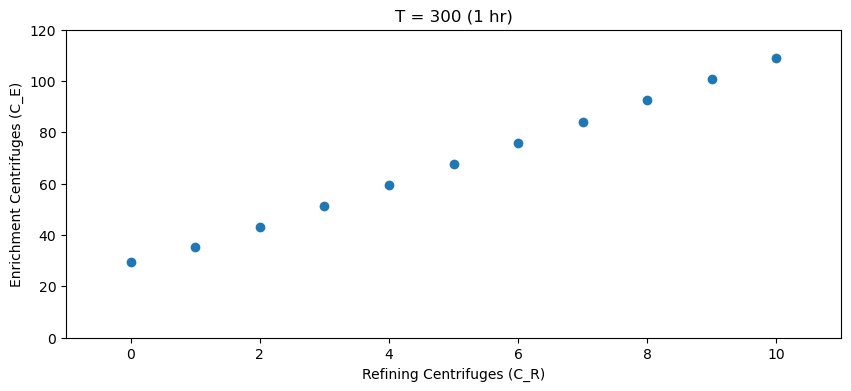

In [13]:
using PyPlot
figure(figsize=(10,4))
scatter(0:10,d_300);
axis([-1,11,0,120]);
xlabel("Refining Centrifuges (C_R)")
ylabel("Enrichment Centrifuges (C_E)")
title("T = 300 (1 hr)")
;

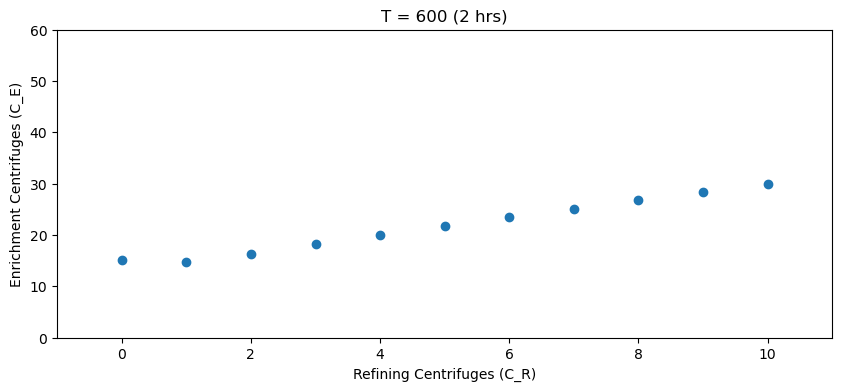

In [14]:
using PyPlot
figure(figsize=(10,4))
scatter(0:10,d_600);
axis([-1,11,0,60]);
xlabel("Refining Centrifuges (C_R)")
ylabel("Enrichment Centrifuges (C_E)")
title("T = 600 (2 hrs)")
;

#### I started adding a red line to show when $C_R = 1$

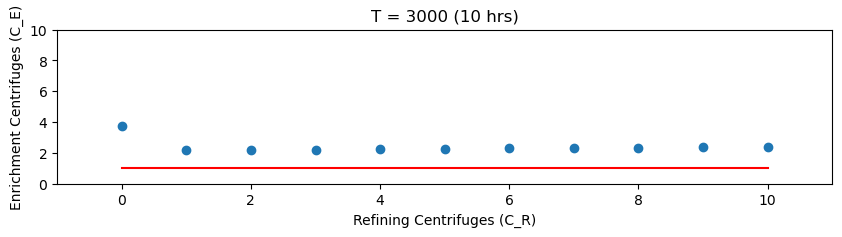

In [15]:
using PyPlot
figure(figsize=(10,2))
plot(0:10, ones(11), "r-")
scatter(0:10,d_3000);
axis([-1,11,0,10]);
xlabel("Refining Centrifuges (C_R)")
ylabel("Enrichment Centrifuges (C_E)")
title("T = 3000 (10 hrs)")
;

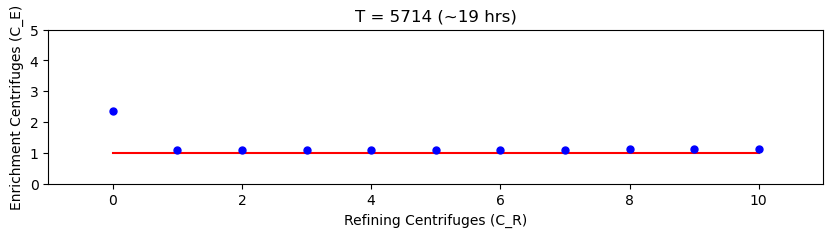

In [16]:
using PyPlot
figure(figsize=(10,2))
plot(0:10, ones(11), "r-")
plot(0:10,d_5714, "b.", markersize=10);
axis([-1,11,0,5]);
xlabel("Refining Centrifuges (C_R)")
ylabel("Enrichment Centrifuges (C_E)")
title("T = 5714 (~19 hrs)")
;

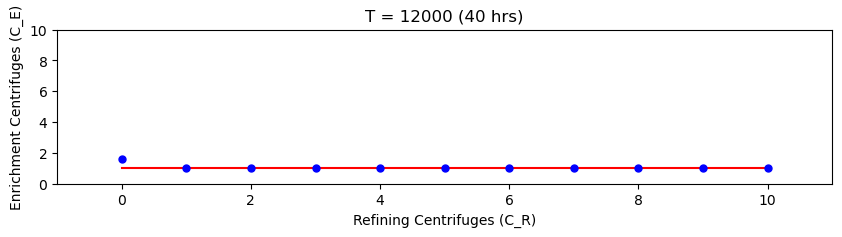

In [17]:
using PyPlot
figure(figsize=(10,2))
plot(0:10, ones(11), "r-")
plot(0:10,d_12000, "b.", markersize=10);
axis([-1,11,0,10]);
xlabel("Refining Centrifuges (C_R)")
ylabel("Enrichment Centrifuges (C_E)")
title("T = 12000 (40 hrs)")
;

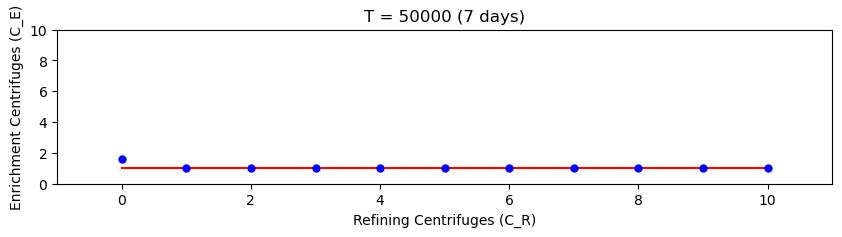

In [18]:
using PyPlot
figure(figsize=(10,2))
plot(0:10, ones(11), "r-")
plot(0:10,d_12000, "b.", markersize=10);
axis([-1,11,0,10]);
xlabel("Refining Centrifuges (C_R)")
ylabel("Enrichment Centrifuges (C_E)")
title("T = 50000 (7 days)")
;

### Experiment 2: $C$ ($C_R$) vs $T$ with different $C_E$

As a very similar but different experiment, I wanted to test the relationship of $C$ vs $T$ for different values of $C_E$

In [19]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E = 5

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
R_R = 0.007

T = 3000

# Results
C_data = zeros(C_E_max+1)

# Create a new model
m = Model()
set_silent(m)

# Define variables
@variable(m, C >= 0)
@variable(m, C_R >= 0)
@variable(m, U_P >= 0)
@variable(m, R_0 >= 0)
@variable(m, T_0 >= 0)

if C_E >= 1
    @variable(m, T_[1:C_E] >= 0)
end
#@variable(m, T >= 0)

# Define objective
@objective(m, Min, C)

# Define constraints
@constraint(m, centrifuges, C == C_R + C_E)

@constraint(m, min_C, C_R >= 1)

@constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

@NLconstraint(m, P_E/R_0 <= T_0)

@NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

@constraint(m, base_rate, R_0 == C_R * R_R)

@constraint(m, u_demand, U_P >= U_D)

@NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )

set_optimizer(m, Ipopt.Optimizer)
; #suppress output

@time(optimize!(m))

println("C_R: ", value(C_R))
println("C_E: ", value(C_E))
println("U_P: ", value(U_P))
println("R_0: ", value(R_0))

println("T 0: ", value(T_0))
for t in 1:C_E
    if value(T_[t]) > 0.1
        println("T ", t, ": ", value(T_[t]))
    end
end
println("T : ", value(T))

println("objective: ", objective_value(m))

println()
println()
println()

  2.108214 seconds (3.89 M allocations: 226.710 MiB, 2.60% gc time, 99.47% compilation time: 100% of which was recompilation)
C_R: 2.2606335032909226
C_E: 5
U_P: 60.000002157312714
R_0: 0.015824434523036456
T 0: 2527.736456301559
T 1: 185.33583030838153
T 2: 96.19444806696713
T 3: 64.95358428529818
T 4: 49.03017019569438
T 5: 76.74953799837307
T : 3000
objective: 7.260633503290922





You can tell from the plot below that small Ts result in large Cs, and the relationship is exponential. There is also a larger amount of $C_R$ required for larger amounts of $C_E$. This makes sense because we need larger amounts of the initial refinement task in order to afford the later enrichment tasks.

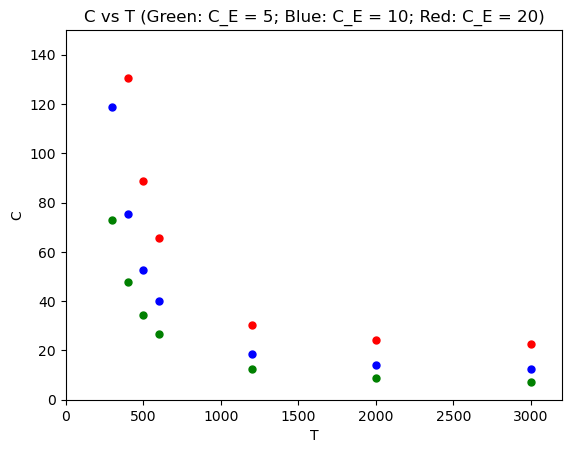

In [20]:
d_T = [300, 400, 500, 600, 1200, 2000, 3000]
d_C = [118.84813063424039, 75.42091290542392, 52.813530883987895, 39.964968054932775, 18.45180206896469, 13.97531734894664, 12.361784365225123]

using PyPlot
plot(d_T,d_C, "b.", markersize=10);
axis([0,3200,0,150]);
xlabel("T")
ylabel("C")
title("C vs T (Green: C_E = 5; Blue: C_E = 10; Red: C_E = 20)")
;

d_T = [300, 400, 500, 600, 1200, 2000, 3000]
d_C = [210.98415551161278, 130.3865485414635, 88.8124637484354, 65.60648036807521, 30.131862543214204, 24.341681103393007, 22.48760022926415]

plot(d_T,d_C, "r.", markersize=10);

d_T = [300, 400, 500, 600, 1200, 2000, 3000]
d_C = [72.73799672898541, 47.729842494028716, 34.461030521445466, 26.69412832783478, 12.327181839181948, 8.695050892712423, 7.260633503290922]

plot(d_T,d_C, "g.", markersize=10);

### Experiment 3: $C$ & $T$ vs $N_R$/$R_R$

I wanted to see how much the confidence level actually affects the results. I used the multi-objective version of the model here.

| Confidence level  |	Failures  | 	Cycles required to get 40   |  Cycles required to get 1 |
|--|--|--|--|
| 10% |	9 out of 10  |	4,595     |     115 |
| 50% |	1 out of 2 	 | 5,667     |     142 |
| 90% |	1 out of 10  |	6,894     |     173 |
| 95% |	1 out of 20  |	7,272     |     182 |
| 99% |	1 out of 100 |	8,015      |     201 |

In [21]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E = 10

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
N_R = [115, 142, 173, 182, 201]

#T = 300

for n in 1:5
    println(N_R[n])

    # Create a new model
    m = Model()
    set_silent(m)

    # Define variables
    @variable(m, C >= 0)
    @variable(m, C_R >= 0)
    @variable(m, U_P >= 0)
    @variable(m, R_0 >= 0)
    @variable(m, T_0 >= 0)

    if C_E >= 1
        @variable(m, T_[1:C_E] >= 0)
    end
    @variable(m, T >= 0)

    # Define objective
    @objective(m, Min, C + T)

    # Define constraints
    @constraint(m, centrifuges, C == C_R + C_E + 1)

    @constraint(m, min_C, C_R >= 1)

    @constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

    @NLconstraint(m, P_E/R_0 <= T_0)

    @NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

    @constraint(m, base_rate, R_0 == C_R / N_R[n])
    @constraint(m, u_demand, U_P >= U_D)

    @NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )
    ; #suppress output

    set_optimizer(m, Ipopt.Optimizer)

    @time(optimize!(m))

    println("C: ", value(C))
    println("C_R: ", value(C_R))
    println("C_E: ", value(C_E))
    println("U_P: ", value(U_P))
    println("R_0: ", value(R_0))

    println("T 0: ", value(T_0))
    for t in 1:C_E
        if value(T_[t]) > 0.1
            println("T ", t, ": ", value(T_[t]))
        end
    end
    println("T : ", value(T))

    println("objective: ", objective_value(m))
            
    println()
    println()
    println()
end

115
  0.010743 seconds (2.36 k allocations: 157.797 KiB)
C: 155.63875412848898
C_R: 144.63875412848898
C_E: 10
U_P: 59.99999940814855
R_0: 1.2577282967694694
T 0: 31.803371280815426
T 1: 27.439955772737232
T 2: 24.129406531707307
T 3: 21.531673959961825
T 4: 19.438912346296462
T 5: 17.716923711792504
T 6: 16.275192035276586
T 7: 15.050447428406441
T 8: 13.997131943878891
T 9: 13.081607066351669
T 10: 18.820810132576977
T : 219.28543220230256
objective: 374.92418633079154



142
  0.010135 seconds (2.27 k allocations: 155.422 KiB)
C: 165.15635379438882
C_R: 154.15635379438882
C_E: 10
U_P: 59.99999940771164
R_0: 1.0856081253125973
T 0: 36.84570800518992
T 1: 31.113680137113505
T 2: 26.925000820040403
T 3: 23.730308006792868
T 4: 21.213315458435645
T 5: 19.179058380970446
T 6: 17.500812827940408
T 7: 16.092641313655633
T 8: 14.89420576576996
T 9: 13.861896122210995
T 10: 19.913328949792476
T : 241.2699557804131
objective: 406.42630957480196



173
  0.011255 seconds (2.39 k allocations: 1

Viewing the plots below, we can actually see that the effect that the confidence level has on the actual change in the system is actually not that much, especially from 143 cycles to 201 cycles, corresponding to 52% confidence and 99% confidence. It might actually be worth putting in the extra effort to have the higher confidence level of achieving the uranium demand.

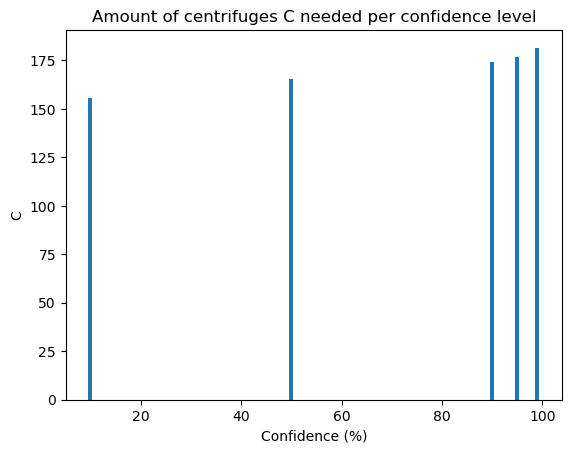

In [22]:
using PyPlot
d_T = [219.28543220230256, 241.2699557804131, 263.42938137892287, 269.3695214367847, 281.2963859157543]
d_C = [155.63875412848898, 165.15635379438882, 174.3394979297472, 176.7440021654507, 181.51126572979524]
d_N = [115, 142, 173, 182, 201]
d_Confidence = [10, 50, 90, 95, 99]

bar(d_Confidence, d_C);
xlabel("Confidence (%)")
ylabel("C")
title("Amount of centrifuges C needed per confidence level")
;

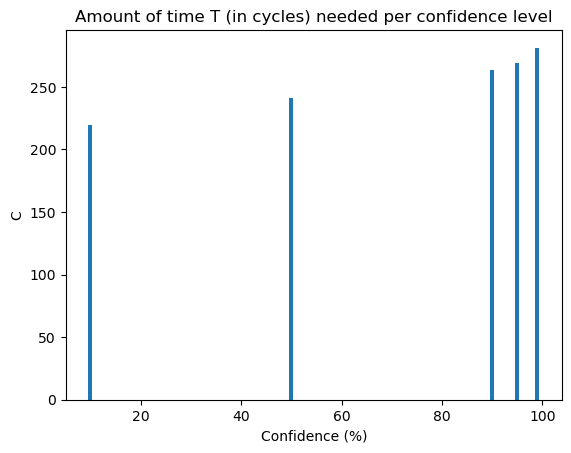

In [23]:
bar(d_Confidence, d_T);
xlabel("Confidence (%)")
ylabel("C")
title("Amount of time T (in cycles) needed per confidence level")
;

### Experiment 4: Just wanted a nice visual of $T_i \forall i \in \{0, C_E\}$

In [24]:
using JuMP, Ipopt

# Data
A = 2
U_D = A*30

C_E = 10

P_E = 40
R_E = 1/5.0
R_P = 1/167.0
T_cycle = 12 # seconds
R_R = 0.007

T = 600

# Create a new model
m = Model()
set_silent(m)

# Define variables
@variable(m, C >= 0)
@variable(m, C_R >= 0)
@variable(m, U_P >= 0)
@variable(m, R_0 >= 0)
@variable(m, T_0 >= 0)

if C_E >= 1
    @variable(m, T_[1:C_E] >= 0)
end
#@variable(m, T >= 0)

# Define objective
@objective(m, Min, C)

# Define constraints
@constraint(m, centrifuges, C == C_R + C_E)

@constraint(m, min_C, C_R >= 1)

@constraint(m, time_total, T_0 + sum(T_[i] for i in 1:C_E) <= T)

@NLconstraint(m, P_E/R_0 <= T_0)

@NLconstraint(m, T_con[i in 1:C_E-1], P_E/(R_0+i*R_E) <= T_[i])

@constraint(m, base_rate, R_0 == C_R * R_R)

@constraint(m, u_demand, U_P >= U_D)

@NLconstraint(m, u_prod, T_0*R_0 + sum(T_[i]*(R_0 + i*R_E) for i in 1:C_E) - P_E*C_E - T*R_P == U_P )

set_optimizer(m, Ipopt.Optimizer)
; #suppress output

@time(optimize!(m))

println("C_R: ", value(C_R))
println("C_E: ", value(C_E))
println("U_P: ", value(U_P))
println("R_0: ", value(R_0))

println("T 0: ", value(T_0))
for t in 1:C_E
    if value(T_[t]) > 0.1
        println("T ", t, ": ", value(T_[t]))
    end
end
println("T : ", value(T))

println("objective: ", objective_value(m))

  0.009870 seconds (2.20 k allocations: 152.906 KiB)
C_R: 29.964968054932775
C_E: 10
U_P: 59.99999945741475
R_0: 0.20975477638452944
T 0: 190.69887558093973
T 1: 97.61936239781083
T 2: 65.60014216594851
T 3: 49.39767098959262
T 4: 39.6135784379535
T 5: 33.06455228174237
T 6: 28.37372906287491
T 7: 24.848505300254157
T 8: 22.10244208115442
T 9: 19.902925976977865
T 10: 28.778221694803253
T : 600
objective: 39.964968054932775


I think this is a really nice visual of what I predicted the assortment of time periods to look like. Notice how each time period gets smaller, but the last $T_{C_E}$ is just the remaining amount, so it could be bigger than previous $T_i$.

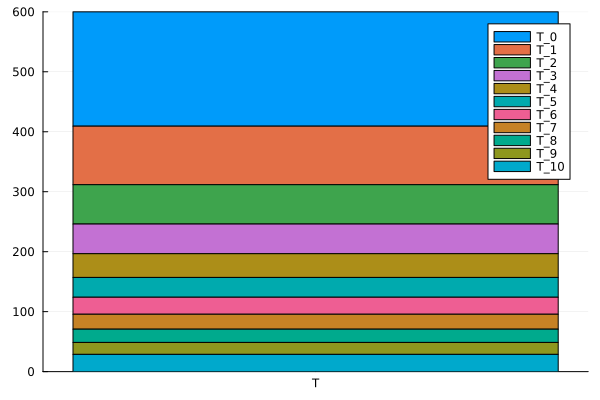

In [25]:
using StatsPlots

T_0 = [190.69887558093973]
T_1 = [97.61936239781083]
T_2 = [65.60014216594851]
T_3 = [49.39767098959262]
T_4 = [39.6135784379535]
T_5 = [33.06455228174237]
T_6 = [28.37372906287491]
T_7 = [24.848505300254157]
T_8 = [22.10244208115442]
T_9 = [19.902925976977865]
T_10 = [28.778221694803253]

# Sum of all T_i is T = 600

ticklabel = "T"
groupedbar([T_0 T_1 T_2 T_3 T_4 T_5 T_6 T_7 T_8 T_9 T_10],
        bar_position = :stack,
        bar_width=0.7,
        xticks=(1:12, ticklabel),
        label=["T_0" "T_1" "T_2" "T_3" "T_4" "T_5" "T_6" "T_7" "T_8" "T_9" "T_10"])

## Conclusion: "'I am Become Death, Destroyer of Worlds' - Oppenheimer" -Me

This was an incredibly fun and challenging project. Factorio was a really fun game to try for the first time, I really enjoyed the recent Oppenheimer movie, and it was a very interesting type of problem to consider. I thought it was very interesting to consider if paying an amount of a resource to increase the production of it was worth it. I could see this being applicable in other "real-world" applications, such as determining if investing money into a system is worth increasing the production of money. This sounds like something any capitalist-loving American would love, and what's more American than money and nuclear bombs? Just kidding lol.

If I had time, I would have put time into the video game Factorio iteself to test out how well these models accurately described the behavior of the system. I totally plan to try this out in my free time after class ends. I will likely put this project on GitHub and update the repo with my results of accuracy in case anyone happened to be interested.

I'm sure I would have fun trying to model other parts of Factorio or other resource management games. My friend that got me into Factorio is playing a super complicated mod that introduces a ton of new crafting recipes and space travel to different planets and such (example shown below, which is a flow chart made by my friend to map out a plan for a specific resource). Breaking down complicated systems like that into simpler components would be super cool. I think there might have been something like NASA came out of military technology and research, so this would further my role playing (maybe a stretch and a bit silly, but definitely fun).

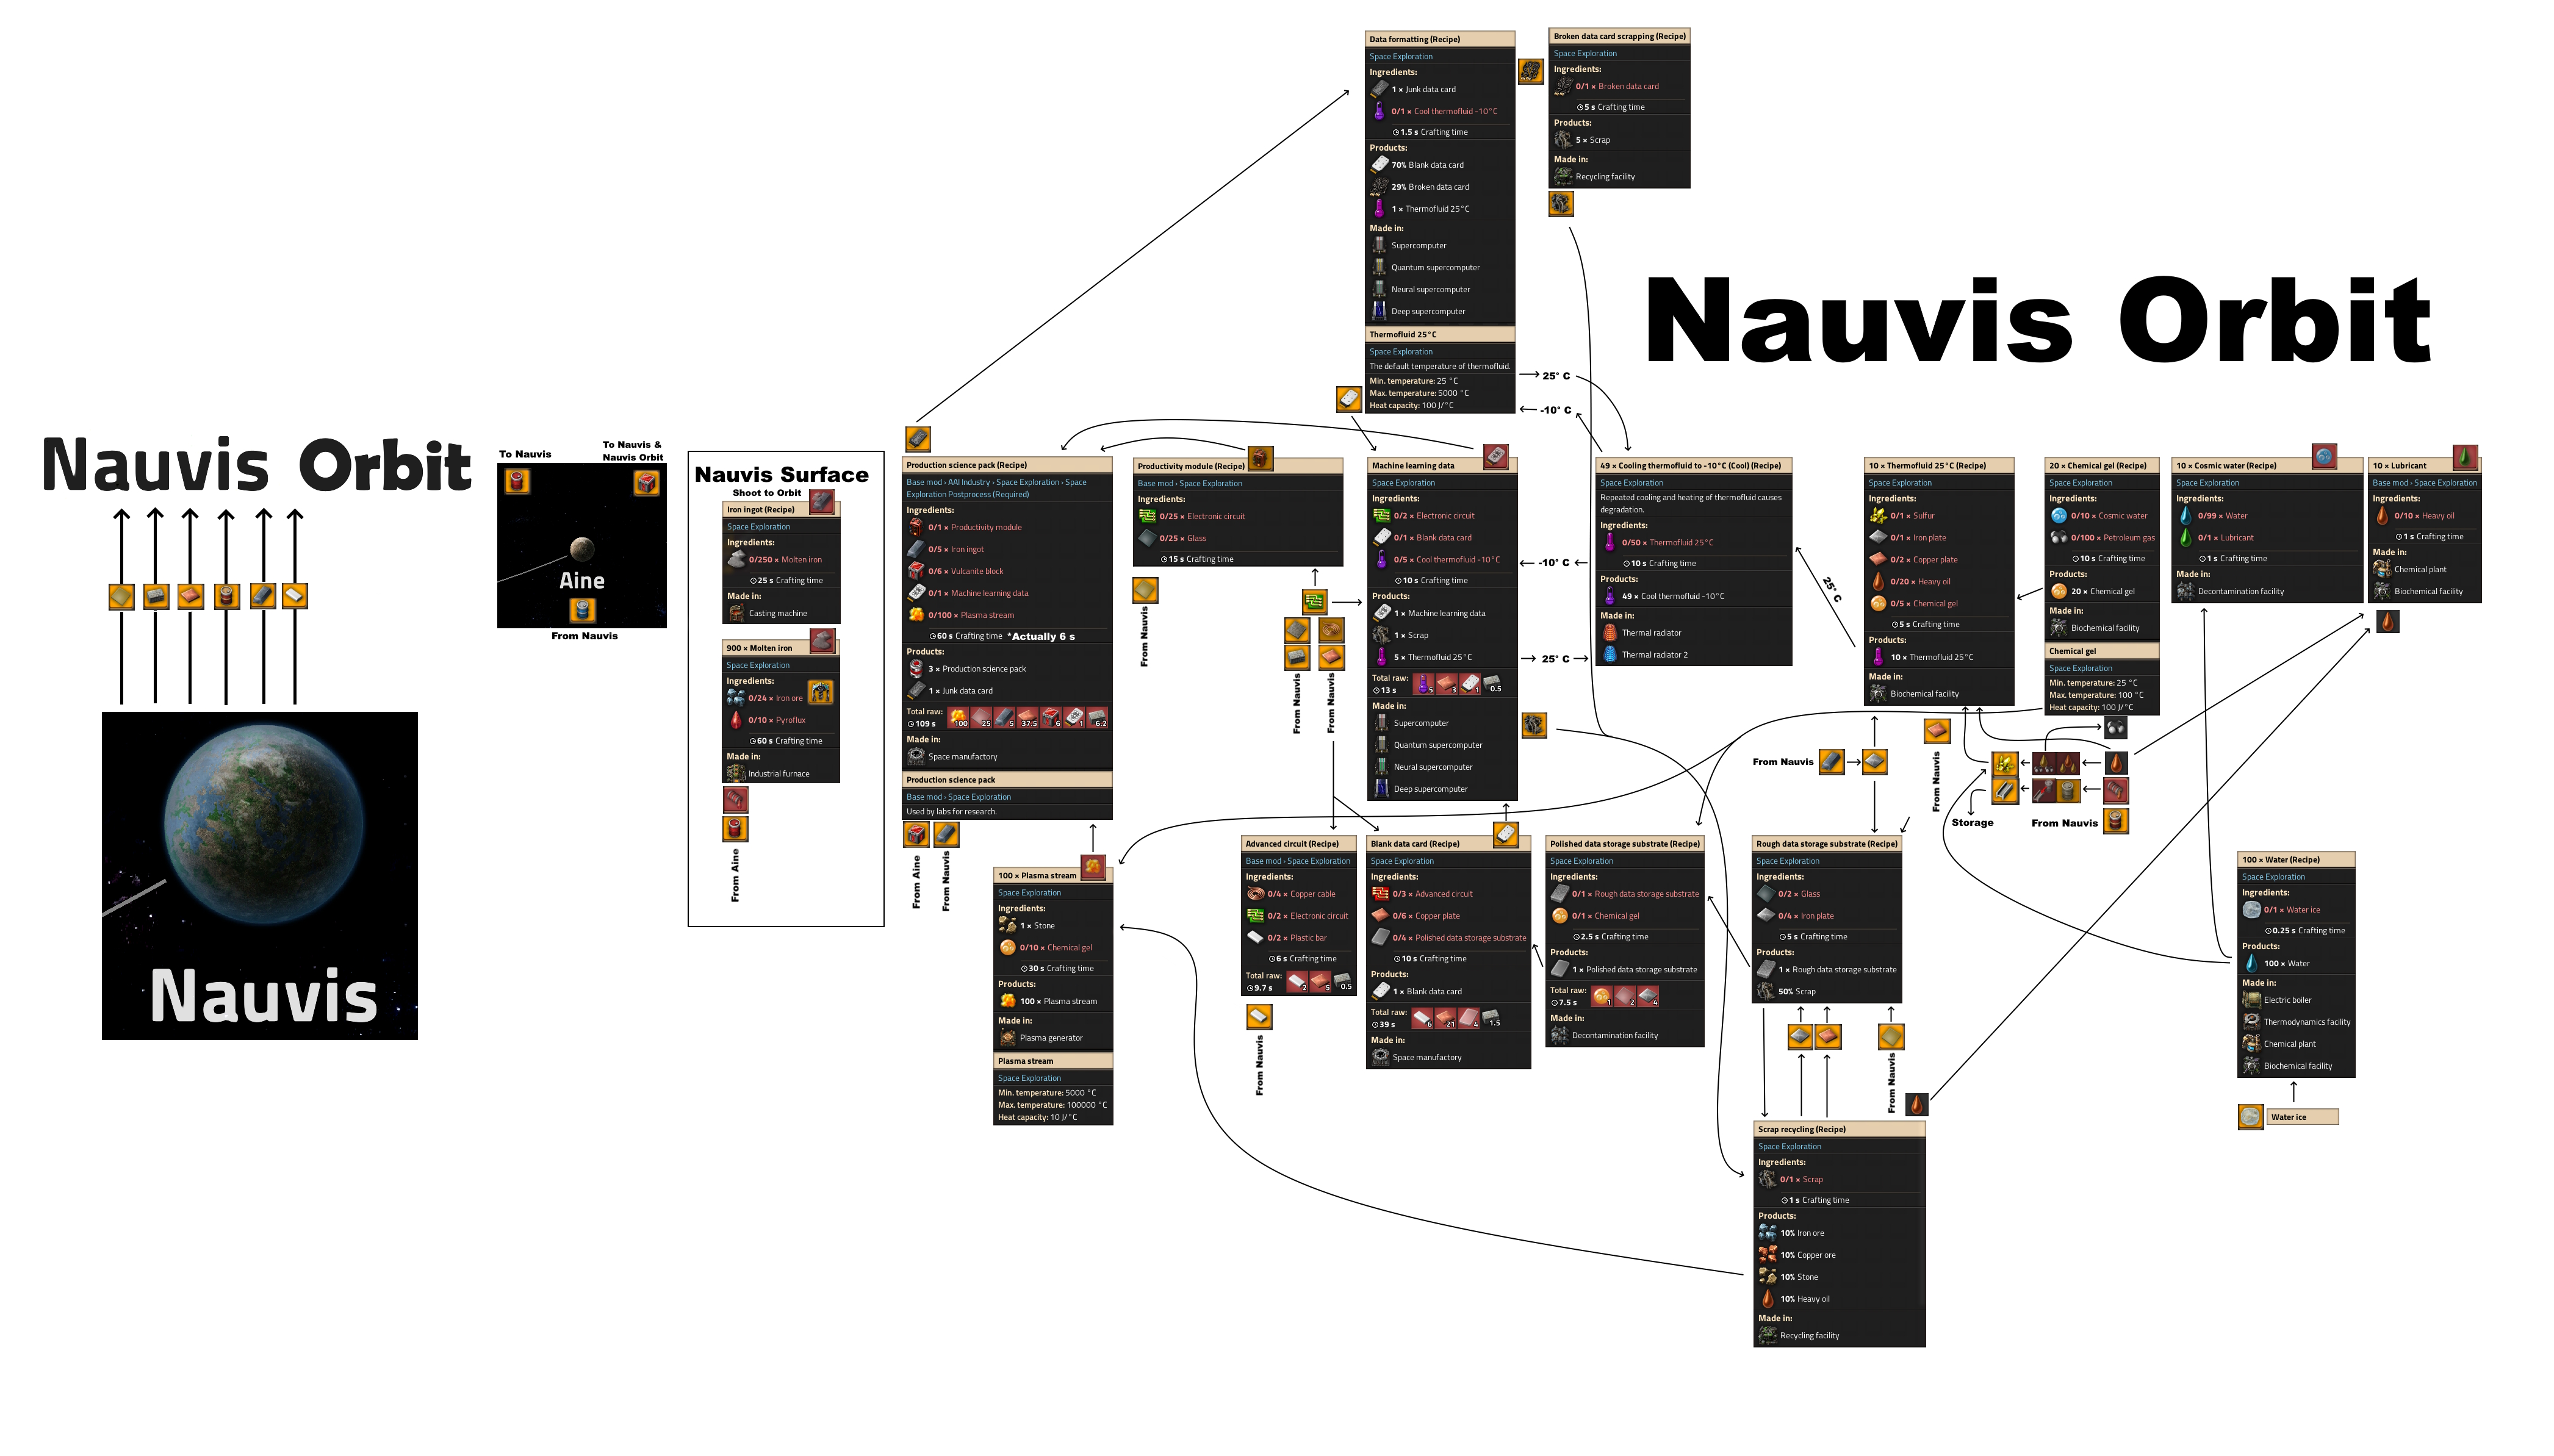

# I hope you found this project as fun and interesting as I did! Thank you very much for your time.